# $\text{The Ishigami Function}$
## Scalar-Output

In [1]:
from utils import *

#### Define parameters

In [2]:
N_set = [100,1000,10000,100000]
num_of_experiments_per_N = 50
model_save_directory = 'data/pick_freeze/ishigami'
model_save_name = f'N_set_{N_set}__numOfExperiments_{num_of_experiments_per_N}'.replace("[","").replace("]","").replace(",","_").replace(" ","")
print(model_save_name)

N_set_100_1000_10000_100000__numOfExperiments_50


#### Create a new model

In [4]:
ishigami = model(model_type="ishigami", vectSize=3, model_save_directory=model_save_directory)

#### Load an existing model (and data)

In [3]:
ishigami = load_model(load_dir=f'{model_save_directory}/{model_save_name}.pkl')

#### Run the Pick-Freeze estimation for the ishigami function's main-effect Sobol' indices

In [ ]:
run_sobols(model=ishigami, N_set=N_set, itersPerN=num_of_experiments_per_N)

#### Save the model and data if desired

In [8]:
ishigami.save_model(file_name=model_save_name)

Model saved successfully.


#### Plot the results

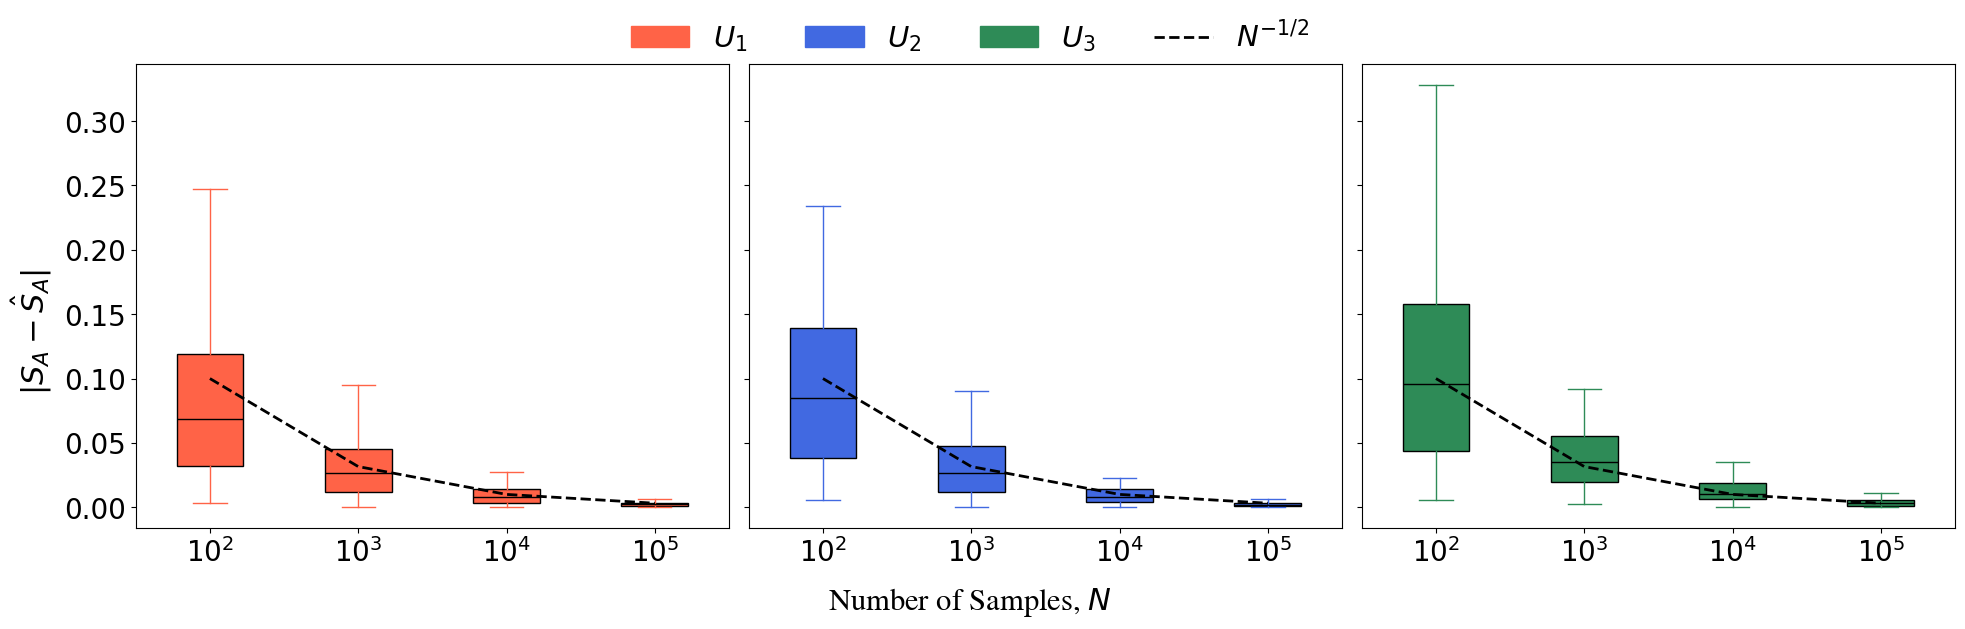

In [4]:
plotter.plot(model=ishigami,
            multi_experiment=True,
            withOutliers=False,
            withTrend=True,
            no_title=True,
            not_differences=False,
            only_singulars=True,
            base_fontsize=20,
            save_fig=True,
            save_directory='figs/ishigami/pick_freeze/scalar',
            fig_name=f'ishigami_pickFreeze_convergence_{model_save_name}.pdf')

# $\text{The Ishigami Function}$
## Vectorized-Set-Output

#### Imports

In [5]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob, escape
import time
import numpy as np
from os import makedirs
import pandas as pd
import matplotlib.pyplot as plt

### Calculating aggr' sobols by calculating weights individually

#### Setup

In [2]:
# interval_domain = [-np.pi, -2.0]
interval_domain = [-np.pi, np.pi]
interval_mesh_resolution = 8
ishigami_indicator_constraint_val = 3
x3_as_mesh = genUniMesh(domain=interval_domain, mesh_resolution=interval_mesh_resolution)
expNum_set = [1000]
N_set = [1000]
N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = 'data/ishigami/indicator/scalar/mesh_x3_'
save_dir += f'{list(np.round(interval_domain, 2))}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
print(save_dir)
makedirs(save_dir, exist_ok=True)
ishi_models_list = []

data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3


#### Run

In [15]:
for x_3 in x3_as_mesh:
    t0 = time.time()
    ishigami = nm.model(model_type='ishigami', vectSize=2)  
    ishigami.specifyX3 = True
    ishigami.x_3 = x_3
    ishigami.ishigami_indicator = True
    ishigami.constraintVal = ishigami_indicator_constraint_val
    for _ in range(expNum_set[0]):
        solvers.run_sobols(model=ishigami, N_set=N_set)
    ishi_models_list.append(ishigami)
    save_name = f"x3_{np.round(x_3,2)}".replace('.', '_').replace('-', 'neg')
    save_model(model=ishigami, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f"Done for x_3: {x_3:0.2f} | T: {t1-t0:0.3f}s")

Done for x_3: -3.14 | T: 44.756s
Done for x_3: -3.00 | T: 45.690s
Done for x_3: -2.86 | T: 45.506s
Done for x_3: -2.71 | T: 45.549s
Done for x_3: -2.57 | T: 45.064s
Done for x_3: -2.43 | T: 44.861s
Done for x_3: -2.29 | T: 44.408s
Done for x_3: -2.14 | T: 44.916s
Done for x_3: -2.00 | T: 44.840s


#### Load data (if not run)

In [ ]:
ishi_models_list = []
files = glob(f"{save_dir}/*.pkl")

for file in files:
    print(file)
    ishi_models_list.append(load_model(load_dir=file))

data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_3_14.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_neg1_57.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_neg2_36.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_0_79.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_neg3_14.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_0_0.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_1_57.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_2_36.dill
data/ishigami/indicator/scalar/mesh_x3_<neg3_14,3_14>_h_8_constraint_3/x3_neg0_79.dill


#### Calculate $S^{\text{clos},Y}_A$ (Aggregate sobol indices)

In [4]:
V_hat_list_all_exps = []
for experim_i_key in range(expNum_set[0]):
    V_hat_list_all_exps.append([np.mean([ishi_models_list[x3_idx].exprimentDataDict[0][experim_i_key]['indiv_output_variance'][f"{N_set[-1]}"]]) for x3_idx in range(len(ishi_models_list))])
V_hat_list_all_exps = np.array(V_hat_list_all_exps)
sum_all_v_hat_all_exps = np.sum(V_hat_list_all_exps,axis=1)
c_j_list_all_exps = V_hat_list_all_exps / sum_all_v_hat_all_exps[:, None]

In [ ]:
first_order_indices = ['01', '10']
sobolVals_clos_aggr_adjusted = {k: [] for k in first_order_indices}
num_of_experiments = len(ishi_models_list[0].exprimentDataDict[0])
N_set = ishi_models_list[0].N_set       
N_final = f"{N_set[-1]}" # can adjust so we can do for multiple N instead of just the N_final                              
num_of_mesh_nodes = len(ishi_models_list)
for sob_idx_str in first_order_indices:
    # for each sample i, compute the weighted sum across models
    for i in range(num_of_experiments):
        weighted_sum = 0.0
        for model_idx in range(num_of_mesh_nodes):
            val = ishi_models_list[model_idx].exprimentDataDict[0][i]['sobolVals_clos'][N_final][sob_idx_str]
            weighted_sum += val * c_j_list_all_exps[model_idx]
        sobolVals_clos_aggr_adjusted[sob_idx_str].append(weighted_sum)
values = np.array([np.asarray(sobolVals_clos_aggr_adjusted['01']).reshape(-1), np.asarray(sobolVals_clos_aggr_adjusted['10']).reshape(-1)])

#### Plot individually calculated Aggr Sobol' Results

ishigami_scalared_mesh_h_8_interval_neg3_14_3_14_Nexp_1000_Nset_1000.pdf


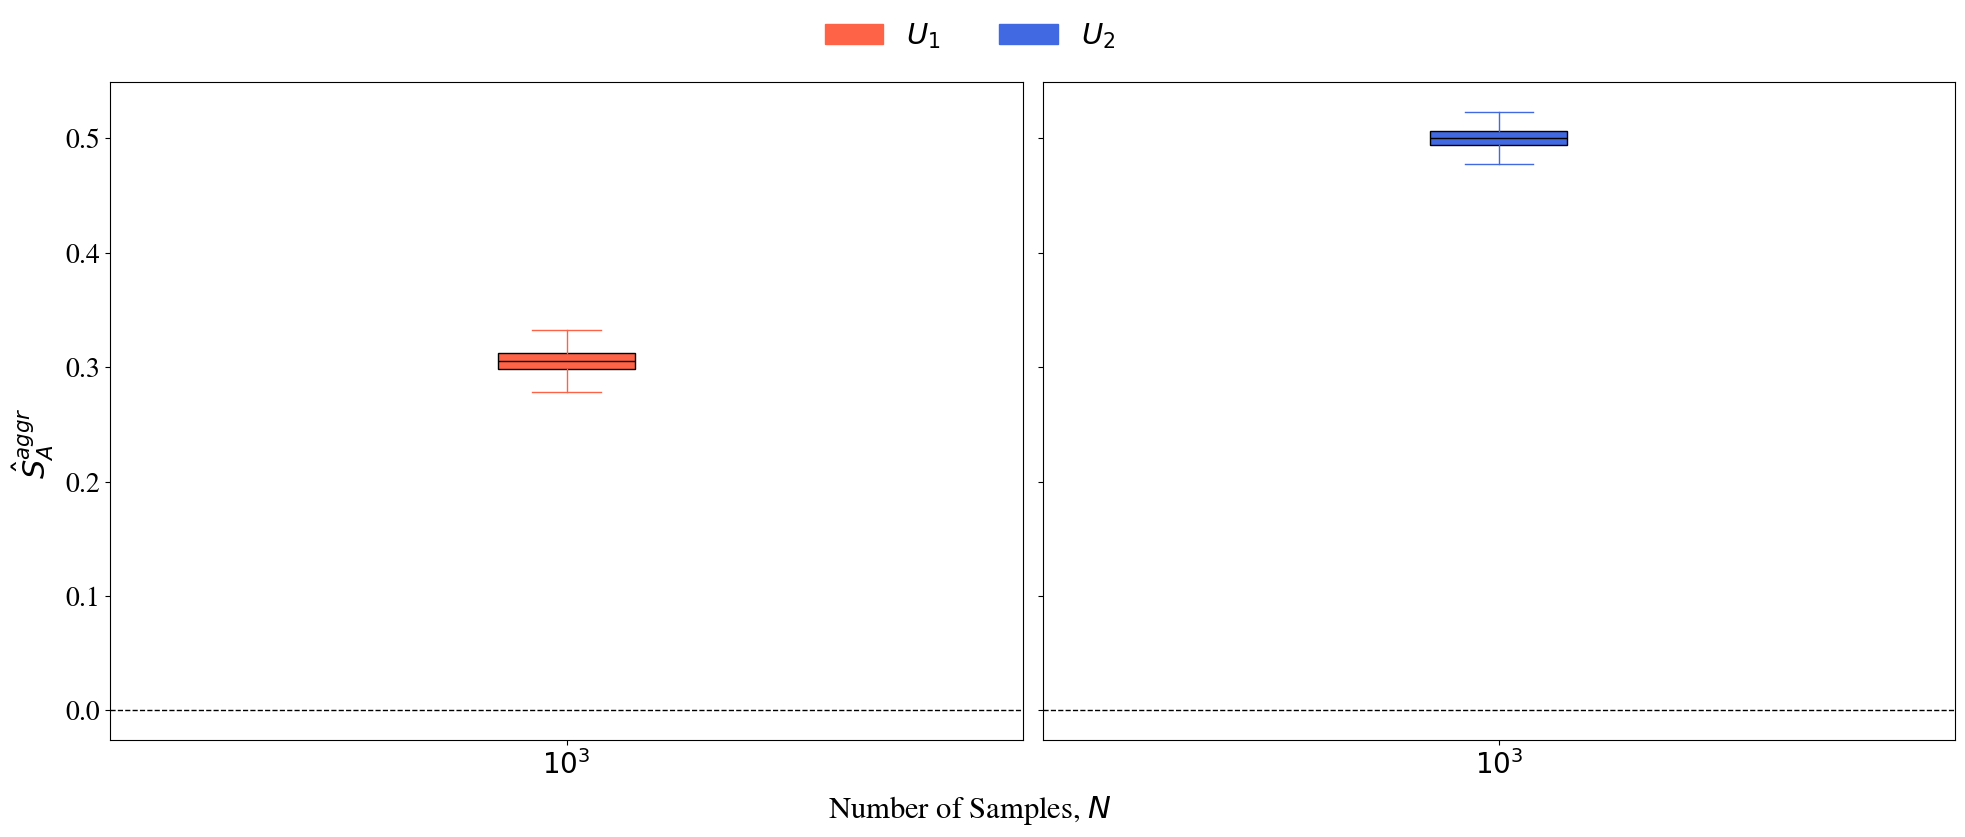

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from os import path, makedirs
import re

def plot_indiv_calculated_S_aggr(values,
                                N_set,
                                base_fontsize=20,
                                save_fig=False,
                                save_directory='',
                                fig_name=''):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    plt.rcParams['font.family'] = 'STIXGeneral'
    colors = ["tomato", "royalblue"]
    base_fontsize = base_fontsize

    for ax, val, color in zip(axes, values, colors):
        box = ax.boxplot(val, patch_artist=True, showfliers=False)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        for patch in box['boxes']:
            patch.set_facecolor(color)
            patch.set_edgecolor("black")
        for whisker in box['whiskers']:
            whisker.set_color(color)
        for cap in box['caps']:
            cap.set_color(color)
        for median in box['medians']:
            median.set_color("black")
        ax.set_xticks(range(1, len(N_set) + 1))         
        myXTicks = [rf"$10^{int(np.log10(x))}$" for x in N_set]
        ax.set_xticklabels(myXTicks)
        ax.tick_params(axis='x', labelsize=base_fontsize)
        ax.tick_params(axis='y', labelsize=base_fontsize)
        for label in ax.get_xticklabels():
            label.set_fontname('STIXGeneral')

    fig.supylabel(r"$\hat{S}^{aggr}_{A}$", fontsize=(base_fontsize+2))
    fig.supxlabel(r"Number of Samples, $N$", fontsize=(base_fontsize+2), y=0.02)
    box_handles = [mpatches.Patch(color=c, label=rf"$U_{i+1}$") for i, c in enumerate(colors)]
    if base_fontsize <= 11:
        vert_space_add_to_legend = 0.02
    else:
        vert_space_add_to_legend = (base_fontsize-14)/100
    fig.legend(handles=box_handles,
                loc="upper center",
                ncol=len(colors) + 1,
                bbox_to_anchor=(0.5, 1.00+vert_space_add_to_legend),
                fontsize=(base_fontsize+1),
                frameon=False) 
    fig.tight_layout(rect=[0.01, 0, 1, 0.97])
    if save_fig:
        if save_directory == '':
            save_directory = model.figsave_directory
        else:
            if not path.exists(save_directory):
                makedirs(save_directory)
        if fig_name == '':
            fig_name = 'ishigami_pickfreeze.pdf'
        plt.savefig(f"{save_directory}/{fig_name}", dpi=900, bbox_inches='tight')
    plt.show()

interval=re.search(r"<(.*?)>", files[0]).group(1)
save_directory = 'figs/ishigami/pick_freeze/mesh/scalar'
fig_name = f'ishigami_scalared_mesh_h_{len(files)-1}_interval_{interval}_Nexp_{num_of_experiments}_Nset_{N_set}.pdf'.replace(',', '_').replace('[','').replace(']','').replace(' ', '')
print(fig_name)
plot_indiv_calculated_S_aggr(values=values, 
                            N_set=N_set, 
                            base_fontsize=20,
                            save_fig=True,
                            save_directory=save_directory,
                            fig_name=fig_name)

#### Plot Aggr Sobols' Results

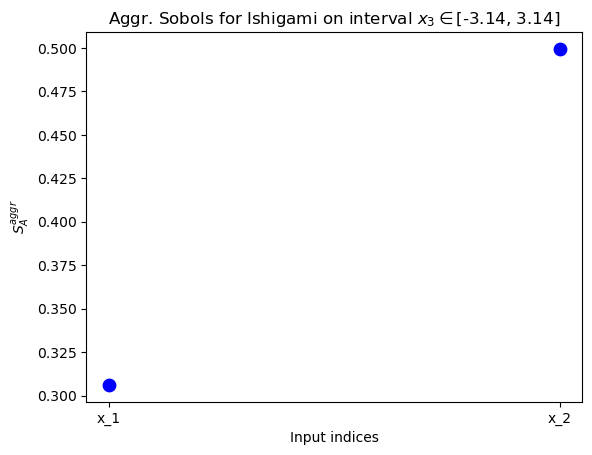

In [66]:
import matplotlib.pyplot as plt

x_axis_keys = list(sobolVals_clos_aggr_adjusted_.keys())
y_axis_values = list(sobolVals_clos_aggr_adjusted_.values())
x_tick_pos = np.arange(len(x_axis_keys))
plt.scatter(x_tick_pos, y_axis_values, color="blue", s=80)
plt.xticks(x_tick_pos, x_axis_keys)
plt.xlabel("Input indices")
plt.ylabel(r"$S^{aggr}_A$")
interval_as_str = f'{list(np.round(interval_domain, 2))}'.replace("np.float64(", "").replace(")", "")
plt.title(r"Aggr. Sobols for Ishigami on interval $x_3\in$" + f"{interval_as_str}")

plt.show()

#### Plot Individual Sobols' Results

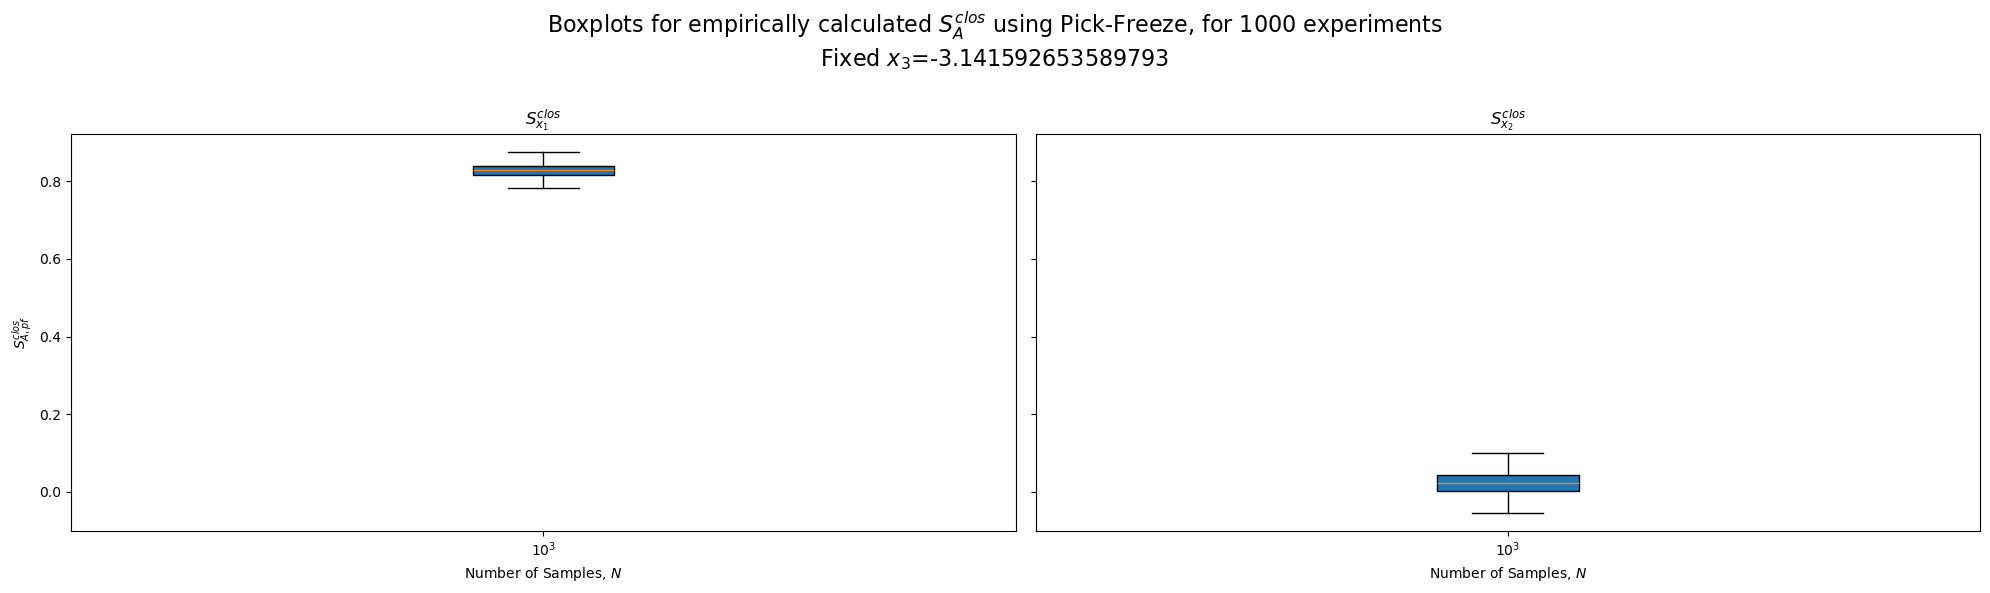

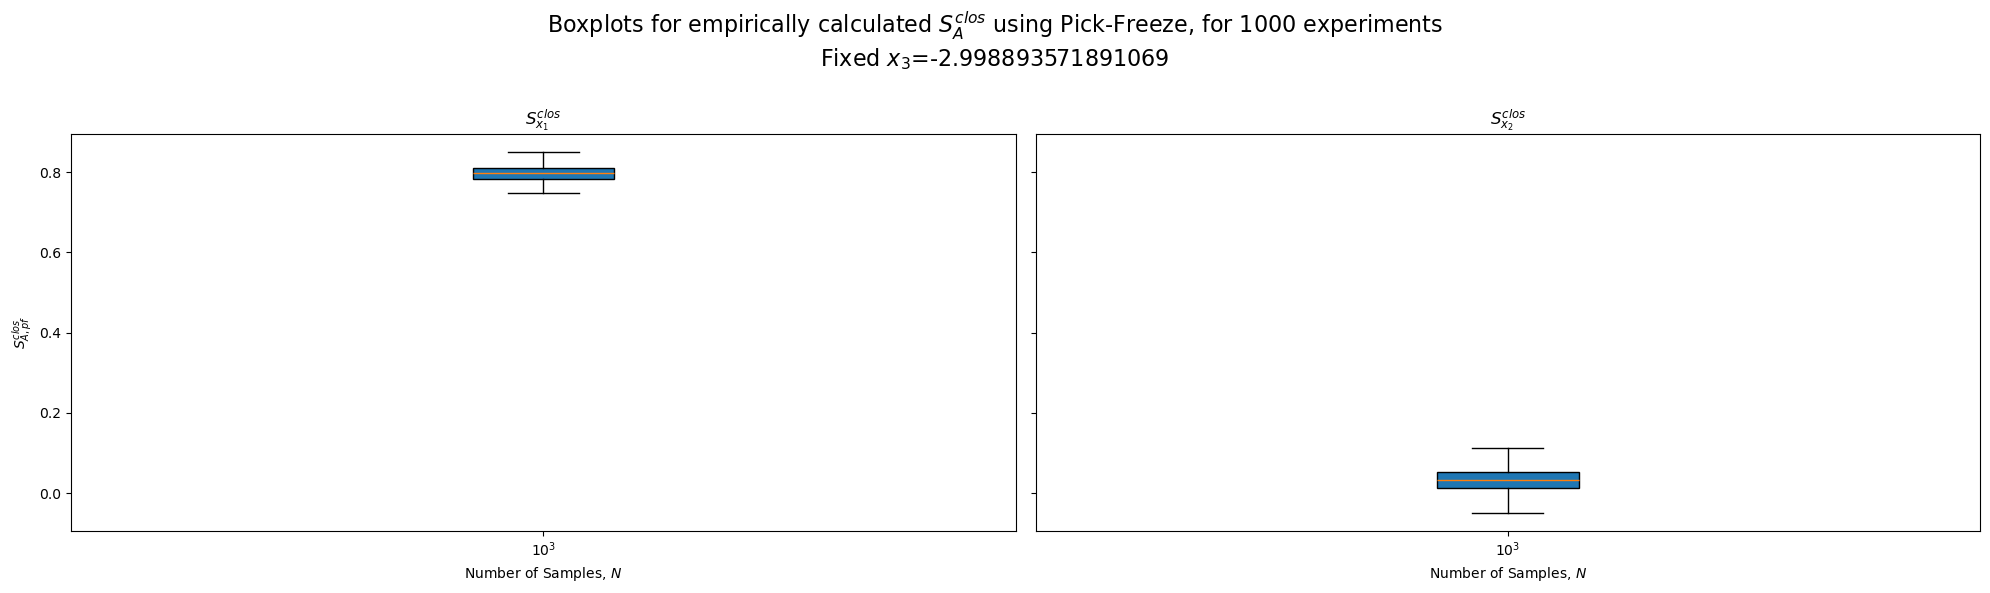

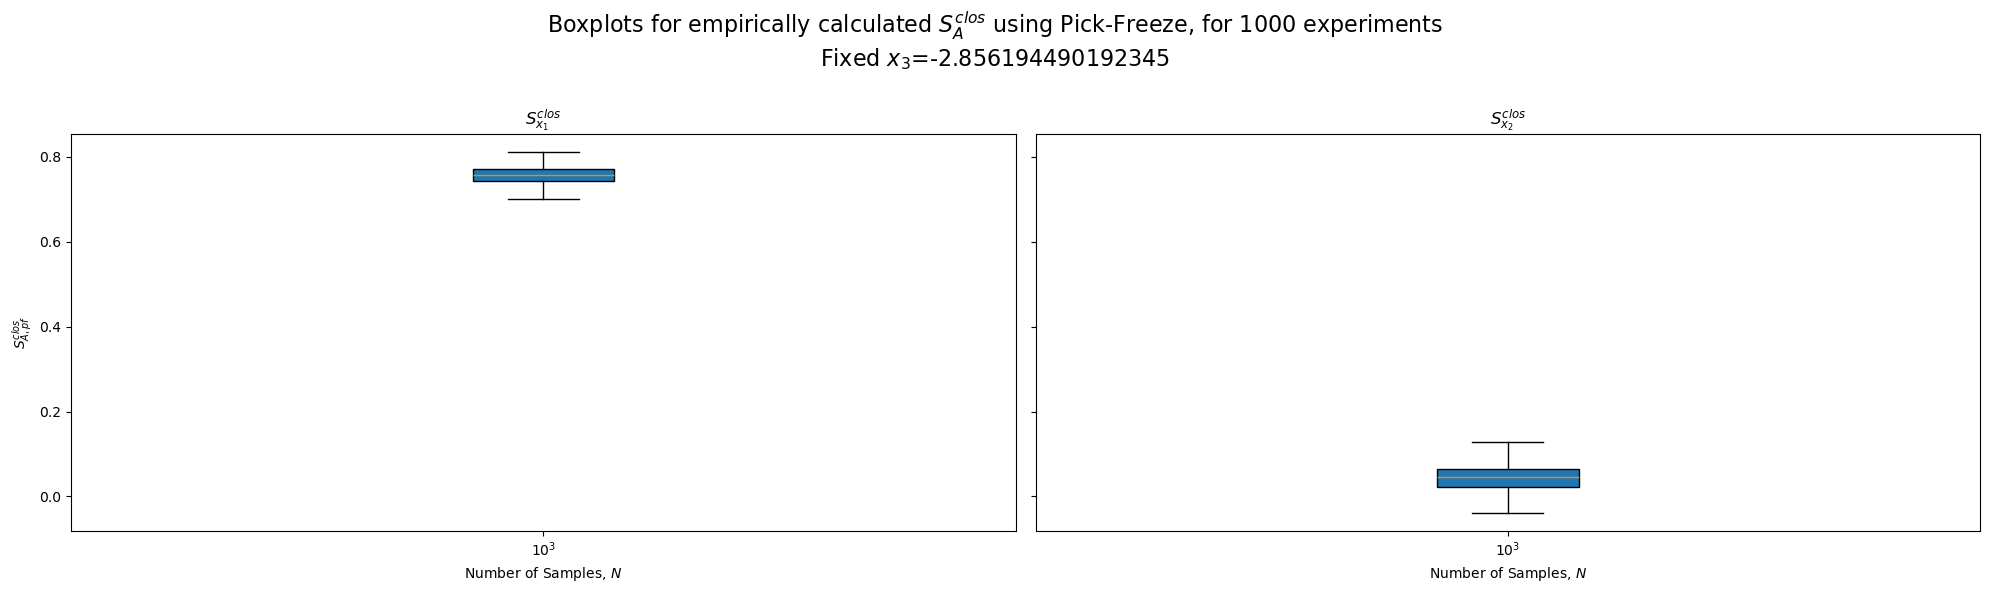

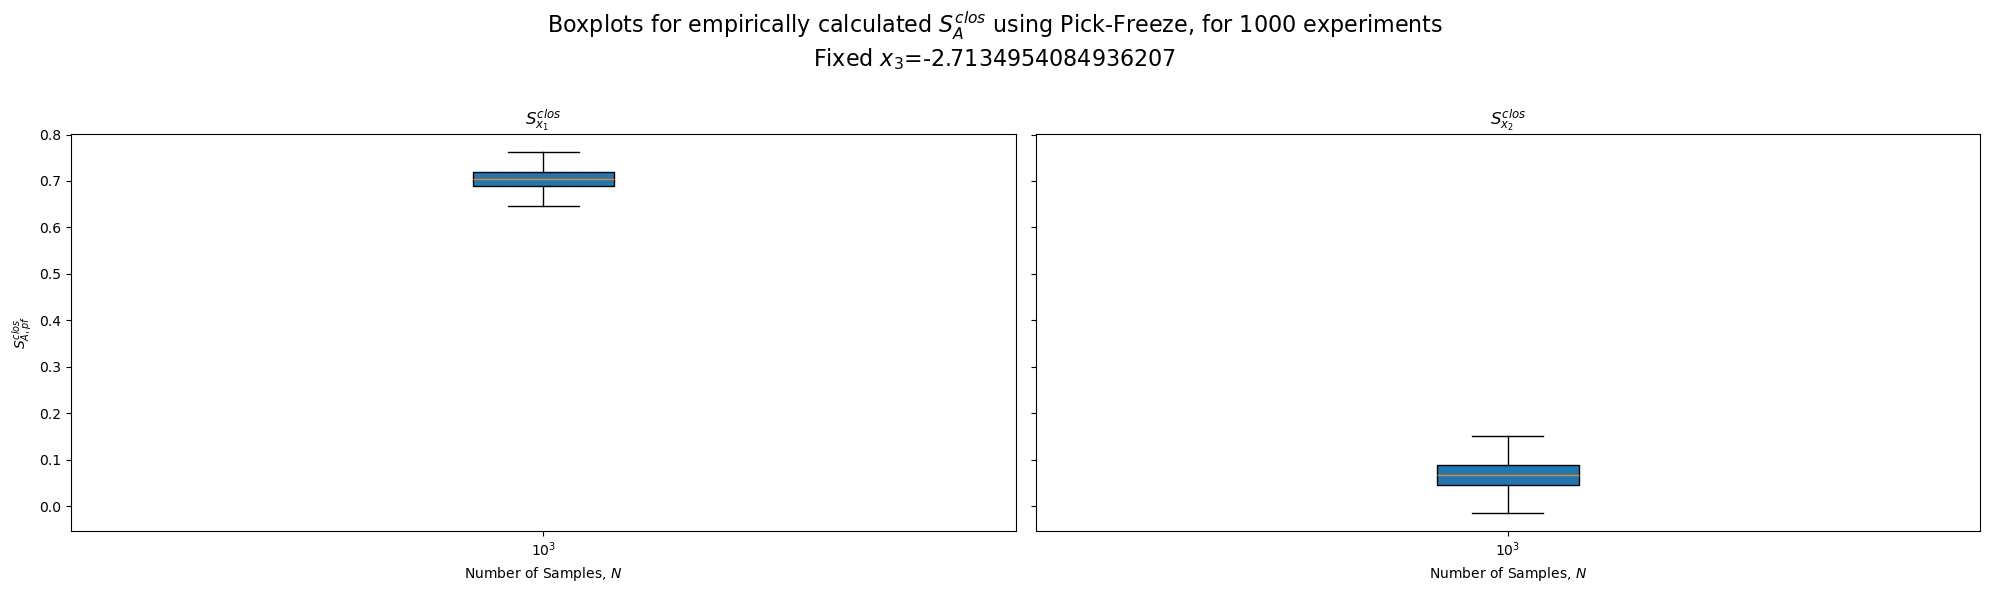

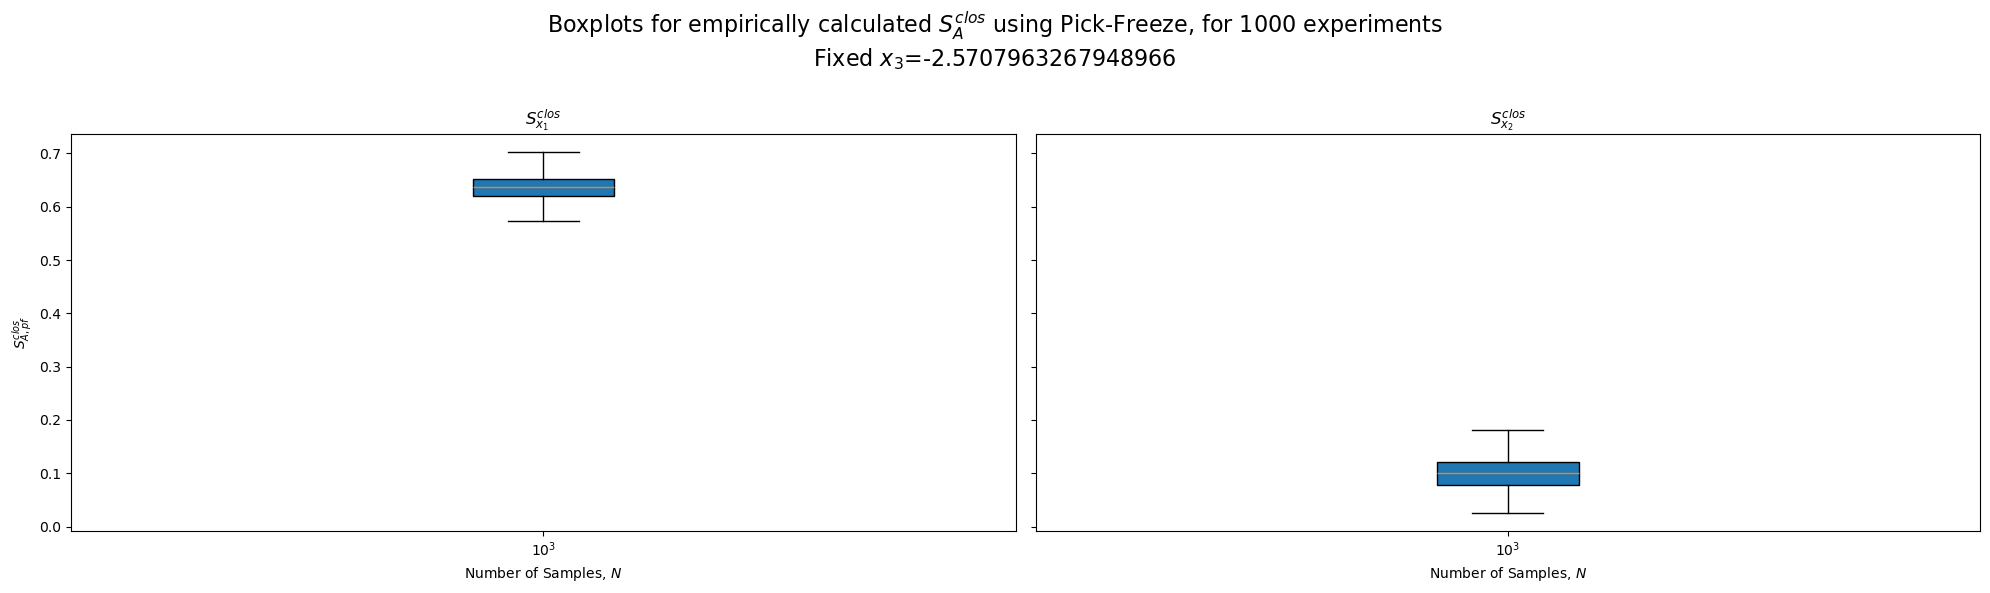

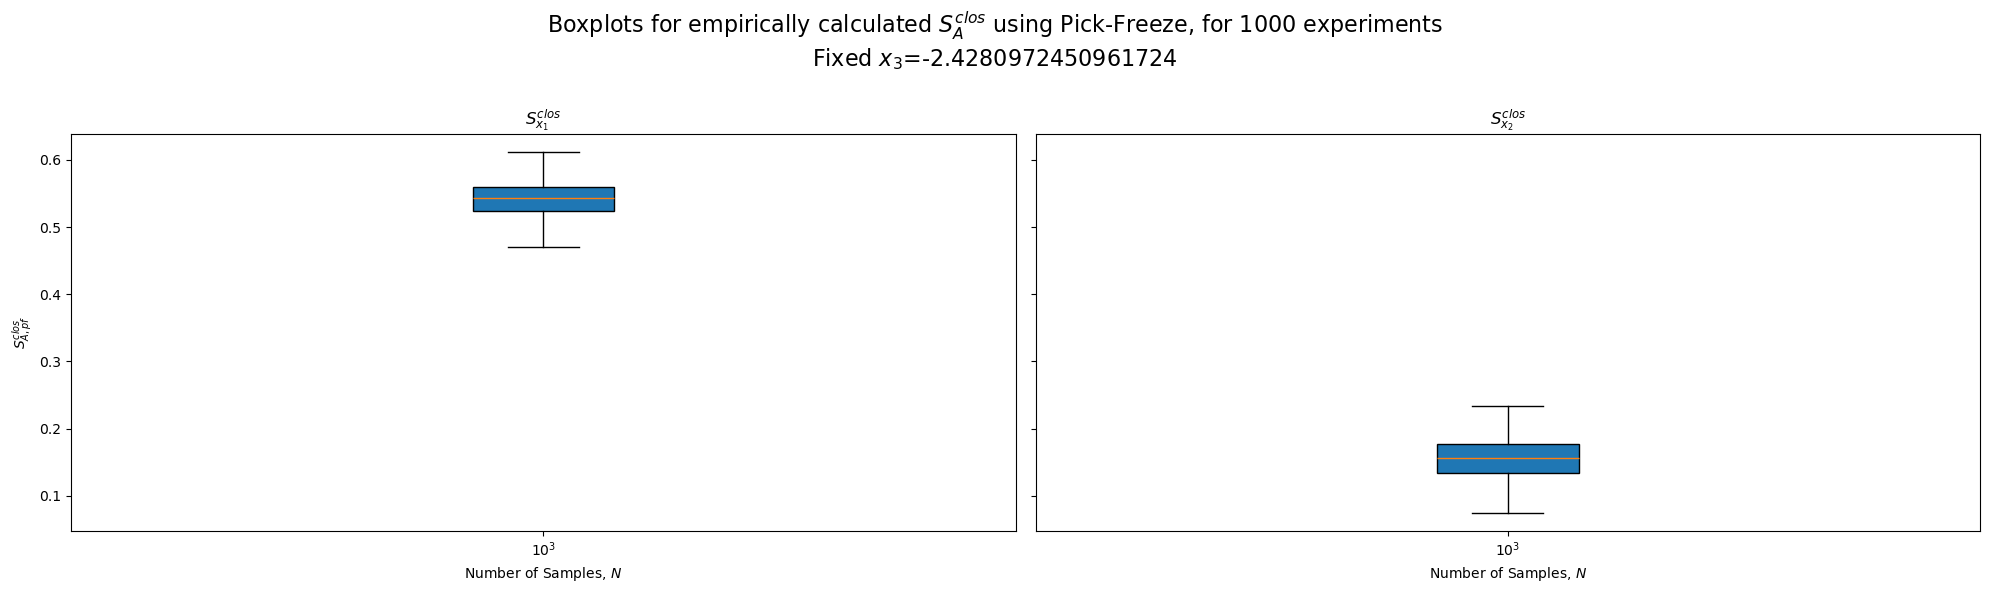

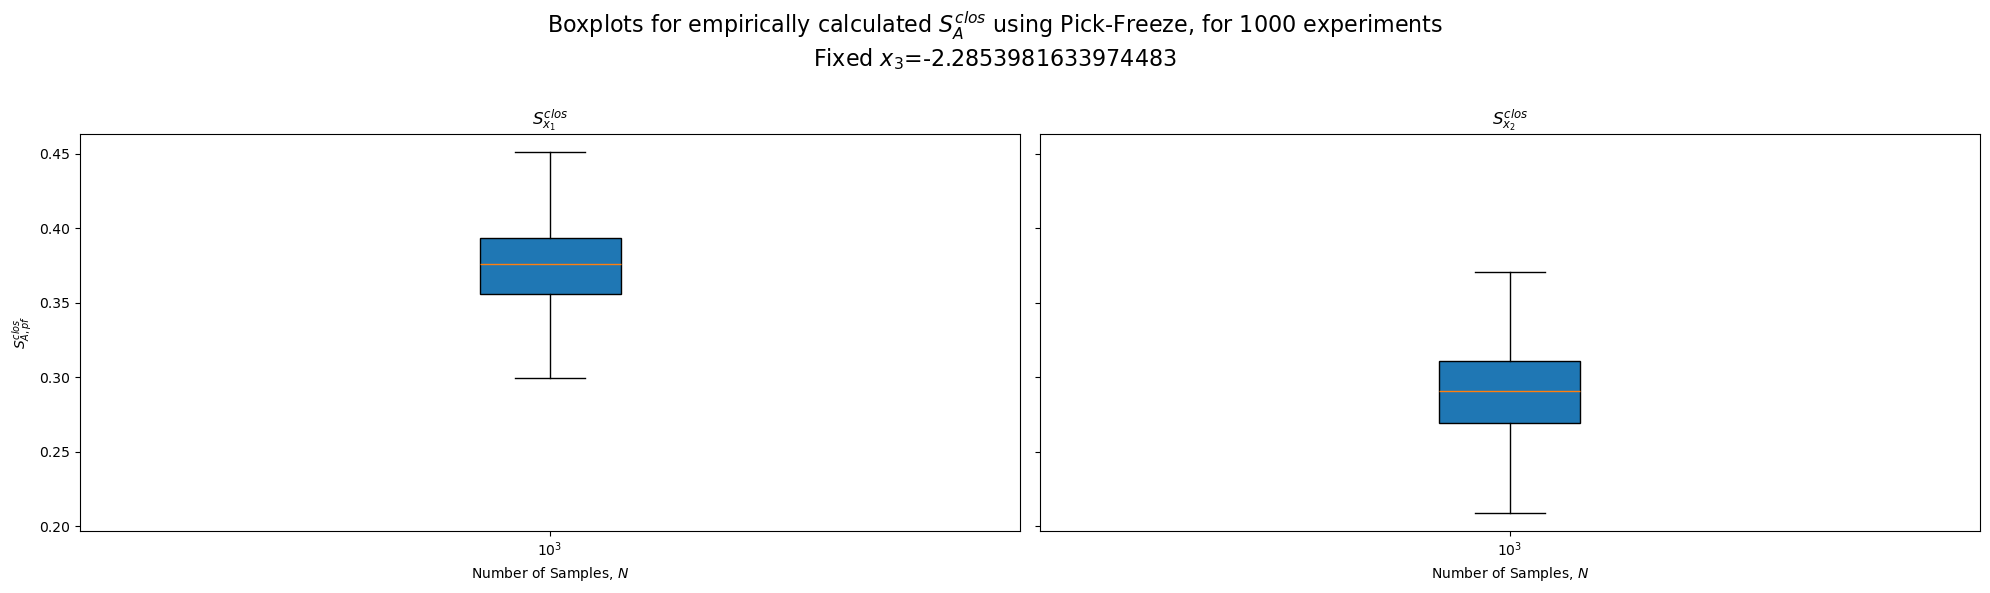

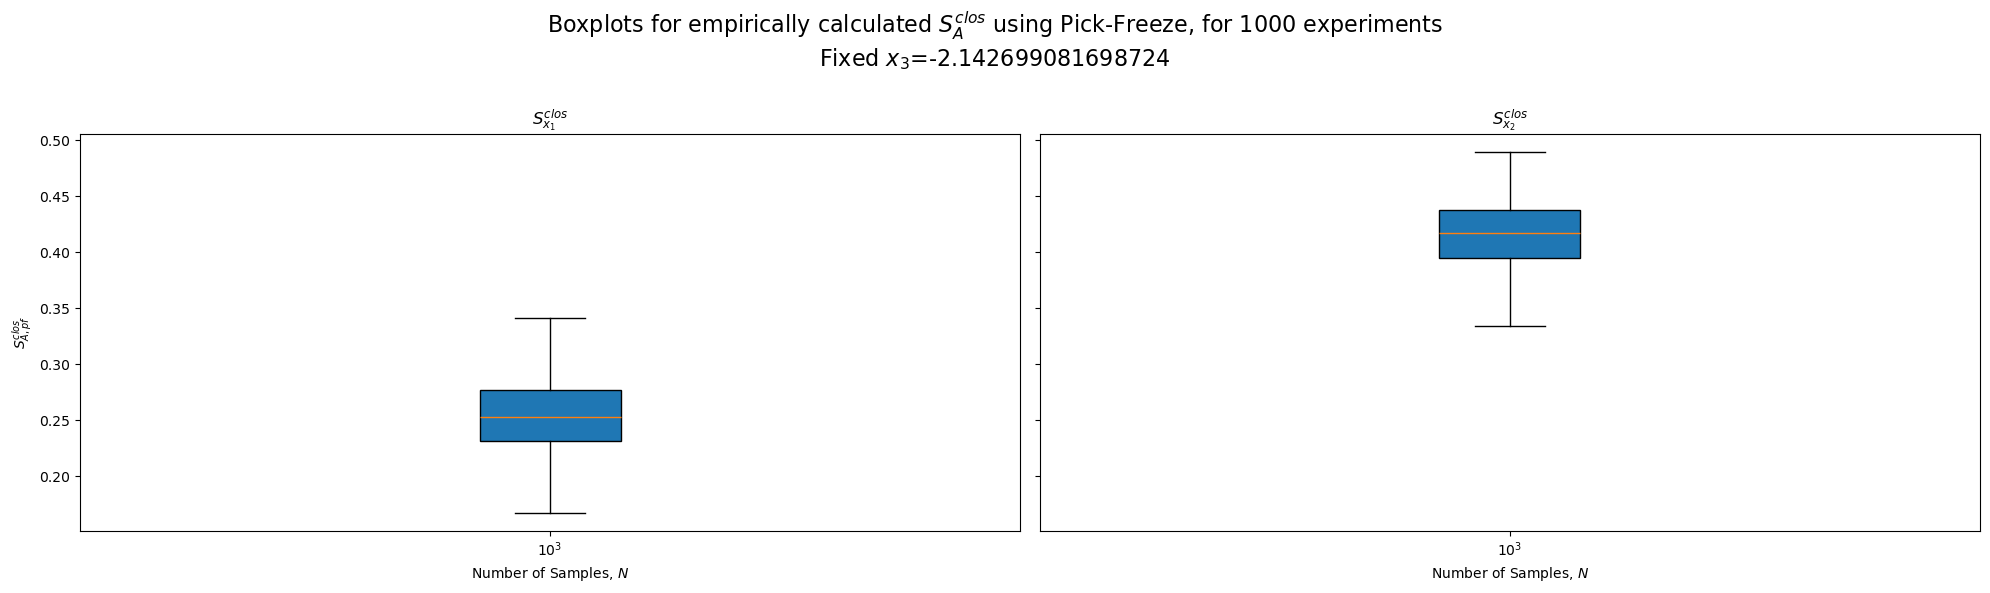

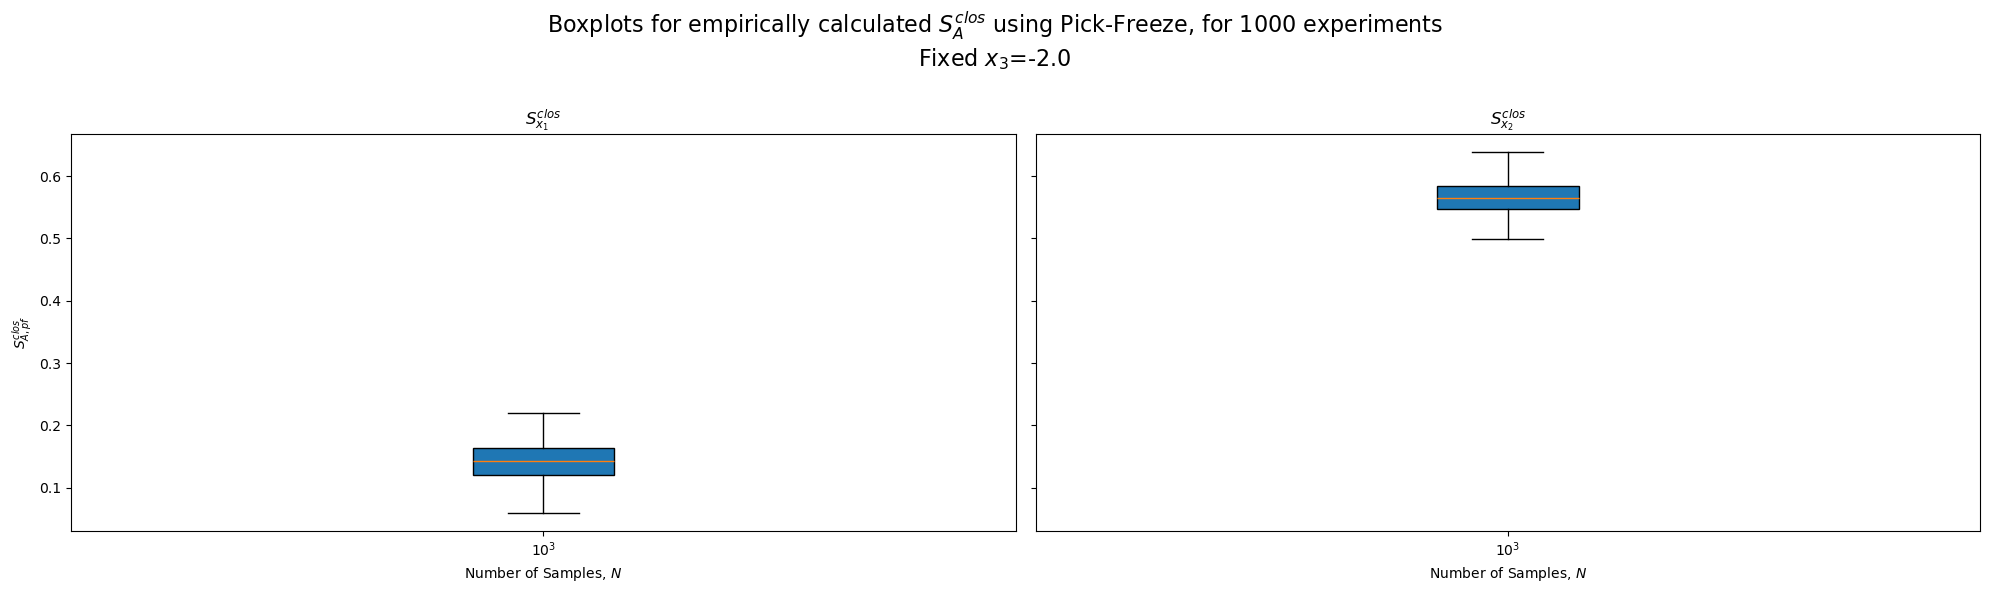

In [ ]:
for model in ishi_models_list:
    plotter.plot(model=model,
            multi_experiment=True,
            withOutliers=False,
            withTrend=False,
            not_differences=True,
            only_singulars=True,
            save_fig=False)
            # save_directory=f'kbsa/sobol_indicator_figs',
            # fig_name=f'sobol_boxplots_x3_{x3}_N_[1e{int(np.log10(N_min))}:1e{int(np.log10(N_max))}]__indicator__NoOutliers__onlySingulars.pdf')

### Calculating aggr' sobols via trace

In [6]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob, escape
import time
import numpy as np
from os import makedirs
import matplotlib.pyplot as plt

#### Setup

In [7]:
interval_domain = [-np.pi, np.pi]
interval_mesh_resolution = 8
ishigami_indicator_constraint_val = 3
expNum_set = [50]
N_set = [100,1000,10000,100000]
N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = 'data/ishigami/indicator/vector/'
save_dir += f'{list(np.round(interval_domain,2))}_expNum_{expNum_set}_Nset_{N_set}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
makedirs(save_dir, exist_ok=True)
ishi_vect_models_list = []

#### Run

In [15]:
t0 = time.time()
ishigami_vect = nm.model(model_type='ishigami_vect', vectSize=2)
ishigami_vect.ishigami_indicator = True
ishigami_vect.constraintVal = ishigami_indicator_constraint_val
ishigami_vect.meshInterval = interval_mesh_resolution
ishigami_vect.set_uniform_1D_mesh(interval=interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=ishigami_vect, N_set=N_set, x_interval_of_interest=interval_domain)
ishi_vect_models_list.append(ishigami_vect)
save_name = "ishigami_vect_model"
save_model(model=ishigami_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | t: {t1-t0:0.3f} (s)")

Model saved successfully.
Done | t: 1155.394 (s)


#### Load data 

In [8]:
from glob import glob
from utils import plotter
from utils.other_utils import load_model

In [ ]:
ishi_vect_models_list = []
files = glob("data/ishigami/indicator/vector/**/*.pkl")
for file in files:
    if 'Nset' not in file:
        continue
    if '100000' not in file:
        continue
    print(file)
    ishi_vect_models_list.append(load_model(load_dir=file))
ishi_vect_models_list

data/ishigami/indicator/vector/<neg3_14,3_14>_expNum_<50>_Nset_<100,1000,10000,100000>_h_8_constraint_3/ishigami_vect_model.pkl


In [ ]:
ishi_vect_models_list[1].ishi_interval = [-np.pi, -1.0]
ishi_vect_models_list[2].ishi_interval = [-np.pi, np.pi]

#### Plot

ishigami_traced_mesh_h_8_interval_neg3_14_3_14_Nexp_50_Nset_100_1000_10000_100000.pdf


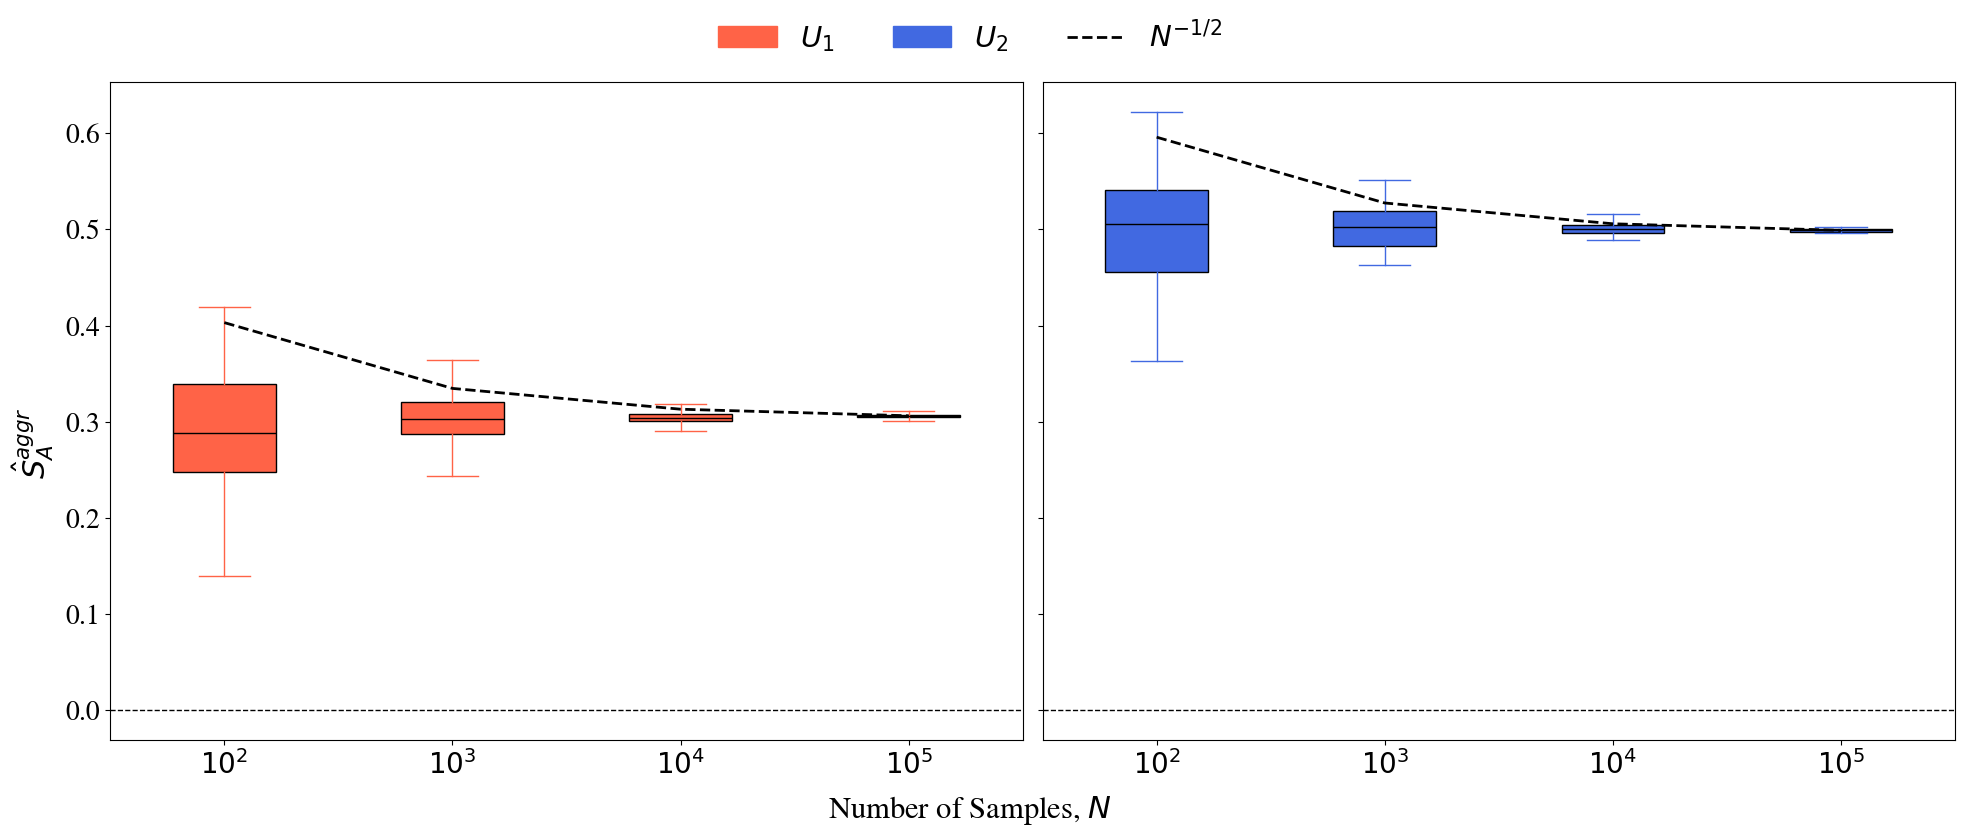

In [ ]:
save_directory = 'figs/ishigami/pick_freeze/mesh/trace'
for model in ishi_vect_models_list:
    interval_domain = model.ishi_interval
    interval_domain_trimmed = [round(x, 2) for x in interval_domain]
    N_set = model.N_set
    num_of_experiments = len(model.exprimentDataDict[str(interval_domain).replace(" ", "")])
    mesh_resolution = model.meshInterval
    fig_name = f'ishigami_traced_mesh_h_{mesh_resolution}_interval_{interval_domain_trimmed}_Nexp_{num_of_experiments}_Nset_{N_set}'.replace(',', '_').replace('[','').replace(']','').replace(' ', '').replace('.','_').replace('-','neg') + '.pdf'
    print(fig_name)
    plotter.plot(model=model,
                    N_set=N_set,
                    plot_type='sobols',
                    not_differences=True,
                    only_singulars=True,
                    interval_toggle=True,
                    multi_experiment=True,
                    which_interval=interval_domain, 
                    which_N=N_set[0],
                    base_fontsize=20,# $$3vfdADFA,
                    plot_which_sobols='closed_aggr',
                    no_title=True,
                    withTrend=True,
                    save_fig=True,
                    save_directory=save_directory,
                    fig_name=fig_name)

----------

# $\text{The 1D-Diffusion Problem}$
## Scalar-Output

In [3]:
from utils import numeric_models as nm
from utils import solvers
import time
import numpy as np
from os import makedirs
from sys import stdout

In [ ]:
#these indices represent the h+1 many spatial-mesh-node-indices. Eg, index 1 translates to spatial point x=1/(h+1), and 32 to x=32/(h+1)
evaluate_at_x_idx_list = [1,32,64] 
interval_mesh_resolution = 128
diffuFen_sobol_vect_len = interval_mesh_resolution+1
P = 3
mu = 1
std = 5
indicator_constraint_val = 0.135
indicator_toggle = False
expNum_set = [20]
N_set = [100, 1000]

N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_toggle:
    save_dir = f'data/1d_diffusion/pick_freeze/indicator/scalar/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
else:
    save_dir = f'data/1d_diffusion/pick_freeze/non-indicator/scalar/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
print(save_dir)
makedirs(save_dir, exist_ok=True)
diffuFen_models_list = []

data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000/


In [ ]:
for x_idx in evaluate_at_x_idx_list:
    save_name = f'1d_diffusion_xIdx_{x_idx}_xVal_{x_idx/129:.2f}_Nset_{N_set}'
    save_name = save_name.replace("np.int64(", "").replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
    if indicator_toggle:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'
    else:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}'
    

    t0 = time.time()
    diffusion_1d = nm.model(model_type='diffusion_1D_both',
                            P=P,
                            mean=mu,
                            std=std,
                            meshInterval=interval_mesh_resolution,
                            indicator_toggle=indicator_toggle,
                            indicator_constraint_val=indicator_constraint_val,
                            FEM_projection=False,
                            model_save_directory=save_dir,
                            model_save_name=save_name)
    t0_inner, t1_inner = 0, 0
    t0_outer = time.time()
    for curr_exp in range(expNum_set[0]):
        if curr_exp != 0:
            stdout.write(f'\r{save_name} | time_prev_experiment_#{curr_exp}: {t1_inner-t0_inner:0.3f} (s). Time so far: {t1_inner-t0_outer:0.3f} (s)')
            stdout.flush()
        t0_inner = time.time()
        solvers.run_sobols(model=diffusion_1d, N_set=N_set, scalarDiffuIdx=x_idx)
        t1_inner = time.time()
    diffuFen_models_list.append(diffusion_1d)
    print('\n')
    diffusion_1d.save_my_model()
    # save_model(model=diffusion_1d, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f" -> {x_idx/129} done! Total time: {t1-t0:0.3f} (s).\n---------------------------------------")

1d_diffusion_xIdx_1_xVal_0_01_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135 | time_prev_experiment_#19: 14.722 (s). Time so far: 276.644 (s)

Model saved successfully.
 -> 0.007751937984496124 done! Total time: 291.357 (s).
---------------------------------------
1d_diffusion_xIdx_32_xVal_0_25_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135 | time_prev_experiment_#19: 14.549 (s). Time so far: 276.667 (s)

Model saved successfully.
 -> 0.24806201550387597 done! Total time: 291.277 (s).
---------------------------------------
1d_diffusion_xIdx_64_xVal_0_50_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135 | time_prev_experiment_#19: 15.169 (s). Time so far: 278.009 (s)

Model saved successfully.
 -> 0.49612403100775193 done! Total time: 292.564 (s).
---------------------------------------


In [ ]:
from glob import glob
from utils.other_utils import load_model

diffuFen_models_list = []
file_sup_dir = 'data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000'
files = glob(f"{file_sup_dir}/*.pkl")
for file in files:
    print(file)
    diffuFen_models_list.append(load_model(load_dir=file))
diffuFen_models_list

data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000/1d_diffusion_xIdx_64_xVal_0_50_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135.pkl
data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000/1d_diffusion_xIdx_1_xVal_0_01_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135.pkl
data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000/1d_diffusion_xIdx_32_xVal_0_25_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135.pkl


1d_diffusion_xIdx_64_xVal_0_50_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135
Showing plot for index: 64


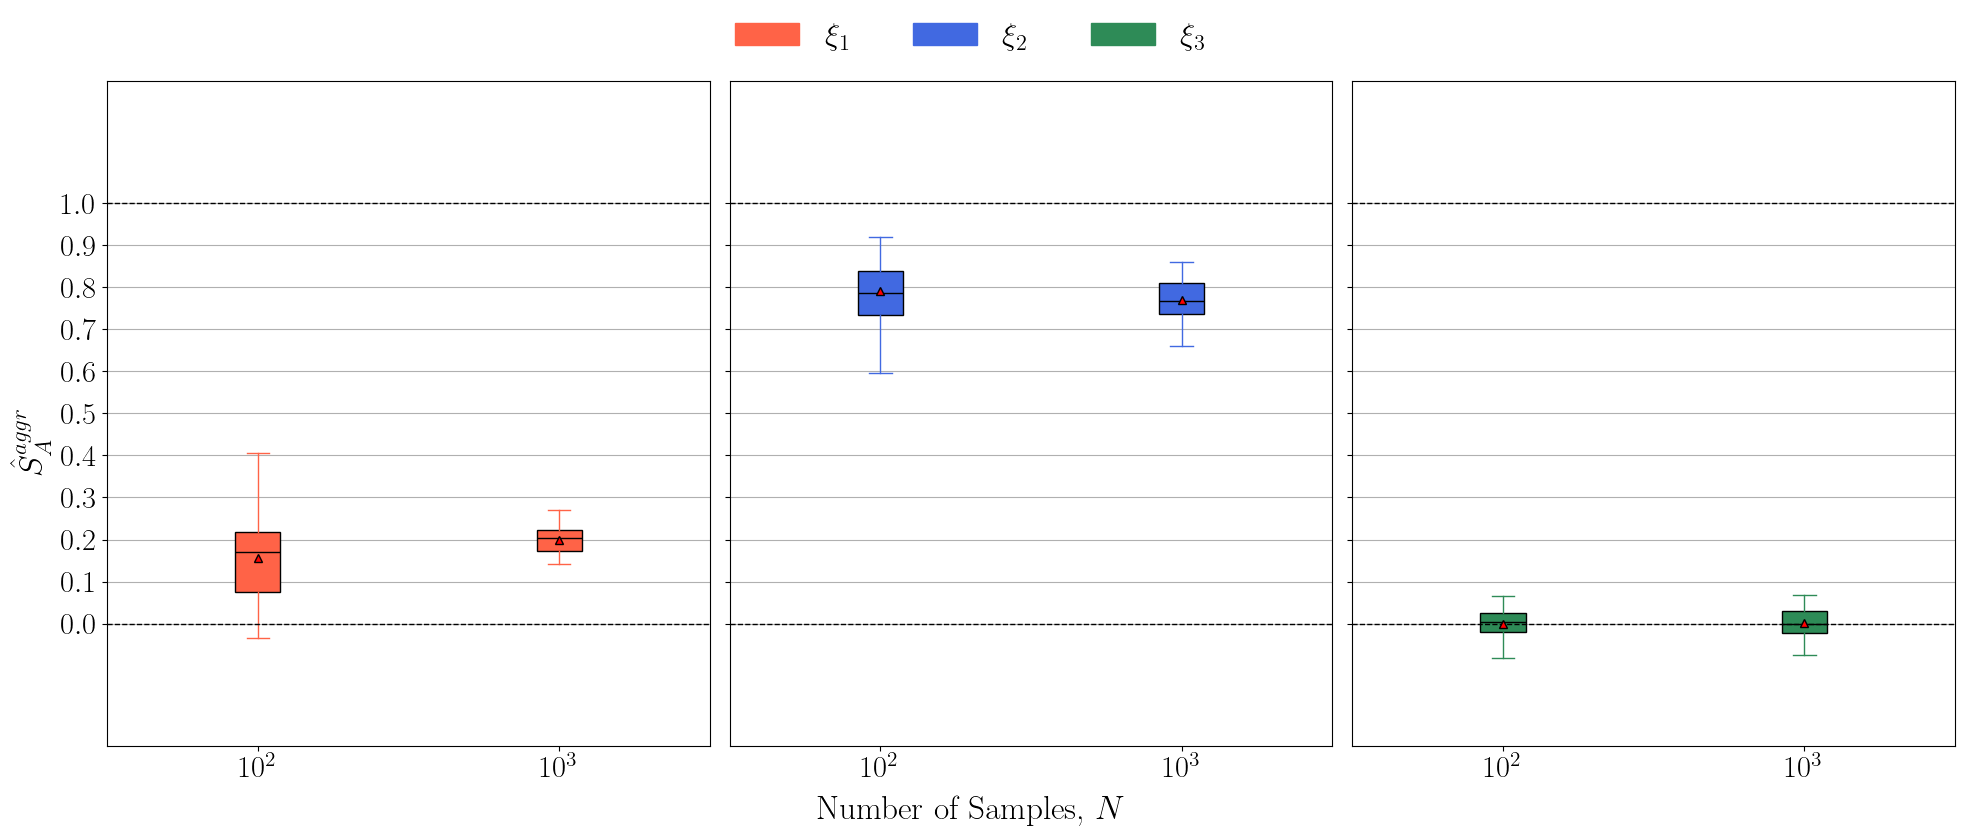

1d_diffusion_xIdx_1_xVal_0_01_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135
Showing plot for index: 1


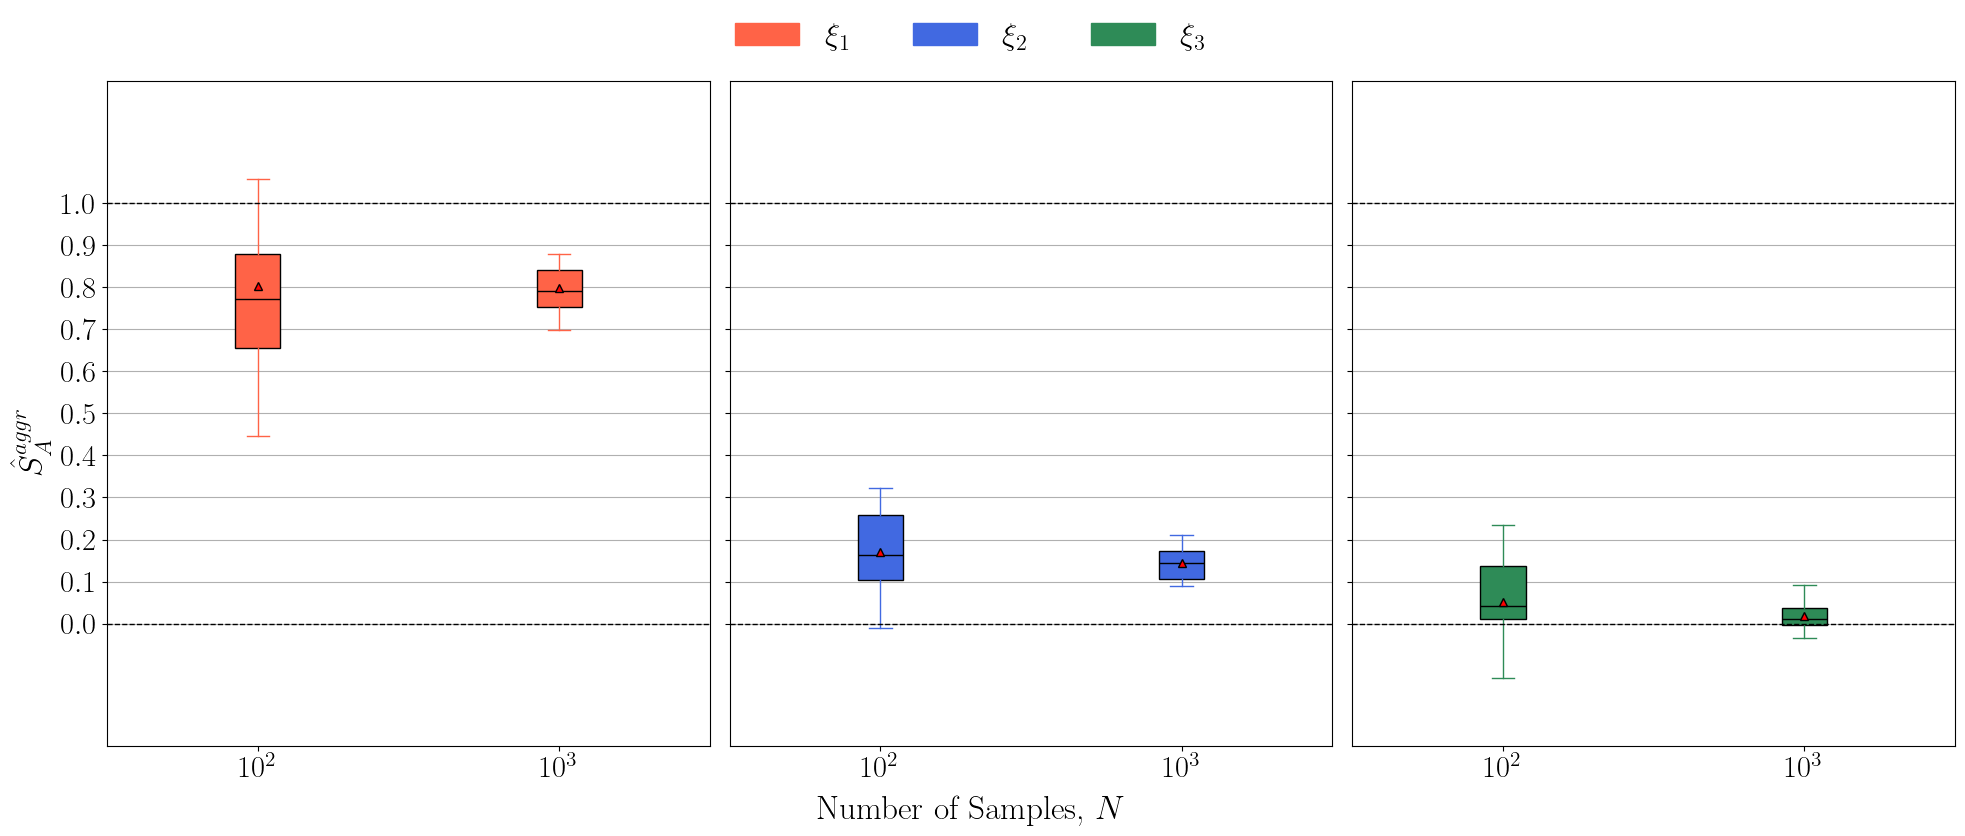

1d_diffusion_xIdx_32_xVal_0_25_Nset_<100,1000>_sobVectLen_129_h_128_constraint_0.135
Showing plot for index: 32


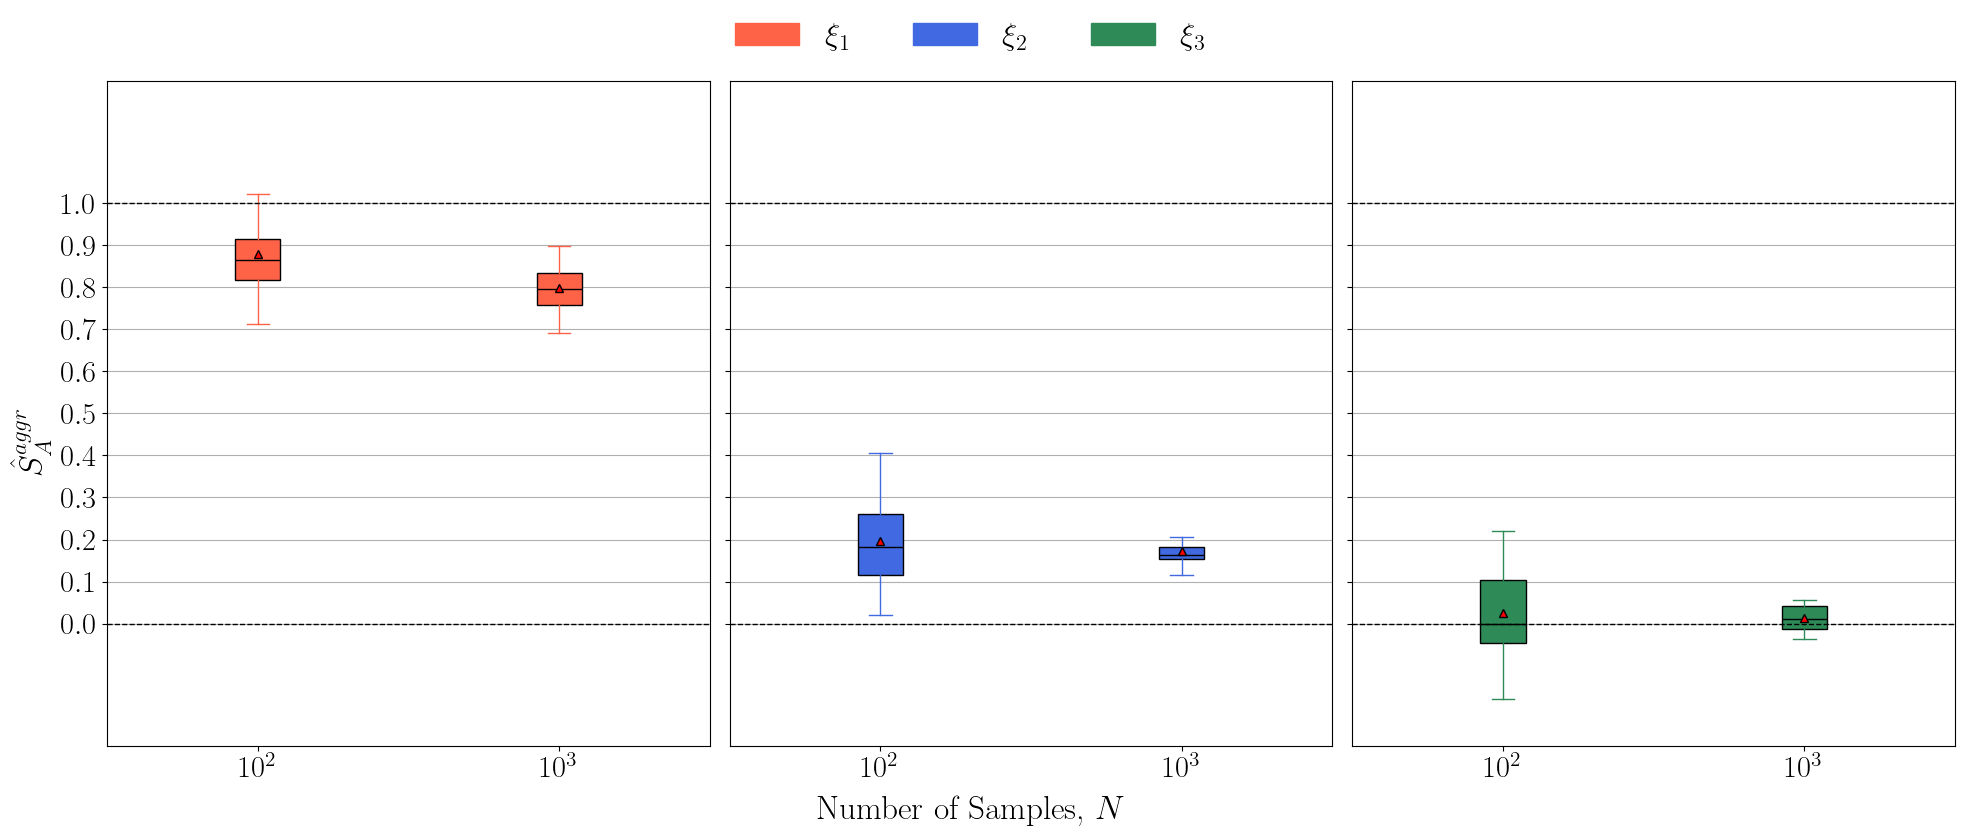

In [ ]:
from utils import plotter
import re
for file in files:
    model = load_model(load_dir=file)
# for model in diffuFen_models_list:
    file_name = file[len(file_sup_dir)+1:-4]
    print(file_name)
    which_index = list(model.exprimentDataDict.keys())[0]
    plotter.plot(model=model,
                N_set=model.N_set,
                only_singulars=True,
                withOutliers=False,
                withTrend=False,
                grid_toggle=True,
                base_fontsize=22,
                save_fig=True,
                which_interval = None,
                which_index = which_index,
                save_directory='figs/1d_diffusion/vbsa/scalar',
                fig_name=file_name)
                # save_directory='figs/toy_2/pick_freeze/traced',
                # fig_name=f'toy_2_convergence_{save_name}.pdf')

# $\text{The 1D-Diffusion Problem}$
## Vectorized-Set-Output

#### Imports

In [2]:
from utils import numeric_models as nm
from utils import solvers
import time
import numpy as np
from os import makedirs
from sys import stdout

#### Setup

In [30]:
# interval_domain_list = [[0.0,1.0],[0.3,0.7],[0.45,0.55],[0.6,1.0]]
# interval_domain_list = [[0.0,1.0],[0.45,0.55]]
interval_domain_list = [[0.0,0.4], [0.6,1.0]]
interval_mesh_resolution = 1024

#this is set equal to mesh_interval when model is initiated. One can change it to maintain a specific resolution to sample equally from
#if the projectOutputToCG option is chosen
projectOutputToCG = False
diffuFen_sobol_vect_len = interval_mesh_resolution+1
P = 3
mu = 1
std = 5
indicator_constraint_val = 0.135
indicator_toggle = True

expNum_set = [20]
N_set = [100,1000,10000]

N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = f'data/1d_diffusion/pick_freeze/indicator/vector/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
if projectOutputToCG:
    save_dir += f"_projd_sobVectLec_{diffuFen_sobol_vect_len}"
print(save_dir)
makedirs(save_dir, exist_ok=True)
diffuFen_models_list = []

data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000/


#### Run

In [26]:
myT = (((2*20)+(14*20)+(155*20))*4)/(60*60)
f"{int(myT)}hr, {(myT-int(myT))*60:.0f}min"

'3hr, 48min'

In [ ]:
for interval_domain in interval_domain_list:
    save_name = f'1d_diffusion_{list(np.round(interval_domain,2))}_Nset_{N_set}'
    save_name = save_name.replace("np.int64(", "").replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
    if not projectOutputToCG:
        save_name += f'_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'
    else:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'

    t0 = time.time()
    diffusion_1d = nm.model(model_type='diffusion_1D_both',
                            P=P,
                            mean=mu,
                            std=std,
                            meshInterval=interval_mesh_resolution,
                            indicator_toggle=indicator_toggle,
                            indicator_constraint_val=indicator_constraint_val,
                            FEM_projection=projectOutputToCG,
                            model_save_directory=save_dir,
                            model_save_name=save_name)
    t0_inner, t1_inner = 0, 0
    t0_outer = time.time()
    for curr_exp in range(expNum_set[0]):
        if curr_exp != 0:
            stdout.write(f'\r{save_name} | time_prev_experiment_#{curr_exp}: {t1_inner-t0_inner:0.3f} (s). Time so far: {t1_inner-t0_outer:0.3f} (s)')
            stdout.flush()
        t0_inner = time.time()
        solvers.run_sobols(model=diffusion_1d, N_set=N_set, x_interval_of_interest=interval_domain)
        t1_inner = time.time()
    diffuFen_models_list.append(diffusion_1d)
    print('\n')
    diffusion_1d.save_my_model()
    # save_model(model=diffusion_1d, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f" -> {interval_domain} done! Total time: {t1-t0:0.3f} (s).\n---------------------------------------")

/Users/farbodchamanian/Desktop/MSc./WS3/Thesis/code_base/pick_freeze/utils/solvers.py:184: RuntimeWarning: invalid value encountered in scalar divide
  s_clos = V_hat_A / V_hat


1d_diffusion_<0_0,0_4>_Nset_<100,1000,10000>_h_1024_constraint_0.135 | time_prev_experiment_#19: 297.199 (s). Time so far: 5940.549 (s)

Model saved successfully.
 -> [0.0, 0.4] done! Total time: 6241.882 (s).
---------------------------------------
1d_diffusion_<0_6,1_0>_Nset_<100,1000,10000>_h_1024_constraint_0.135 | time_prev_experiment_#19: 282.676 (s). Time so far: 5600.670 (s)

Model saved successfully.
 -> [0.6, 1.0] done! Total time: 5883.682 (s).
---------------------------------------


#### Load data

In [ ]:
from glob import glob
from utils.other_utils import load_model

diffuFen_models_list = []
file_sup_dir = 'data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000'
files = glob(f"{file_sup_dir}/*.pkl")
for file in files:
    print(file)
    diffuFen_models_list.append(load_model(load_dir=file))
diffuFen_models_list

data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000/1d_diffusion_<0_0,0_4>_Nset_<100,1000,10000>_h_1024_constraint_0.135.pkl
data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000/1d_diffusion_<0_45,0_55>_Nset_<100,1000,10000>_h_1024_constraint_0.135.pkl
data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000/1d_diffusion_<0_0,1_0>_Nset_<100,1000,10000>_h_1024_constraint_0.135.pkl
data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000/1d_diffusion_<0_6,1_0>_Nset_<100,1000,10000>_h_1024_constraint_0.135.pkl


1d_diffusion_<0_0,0_4>_Nset_<100,1000,10000>_h_1024_constraint_0.135
Showing plot for interval: [0.0,0.4]


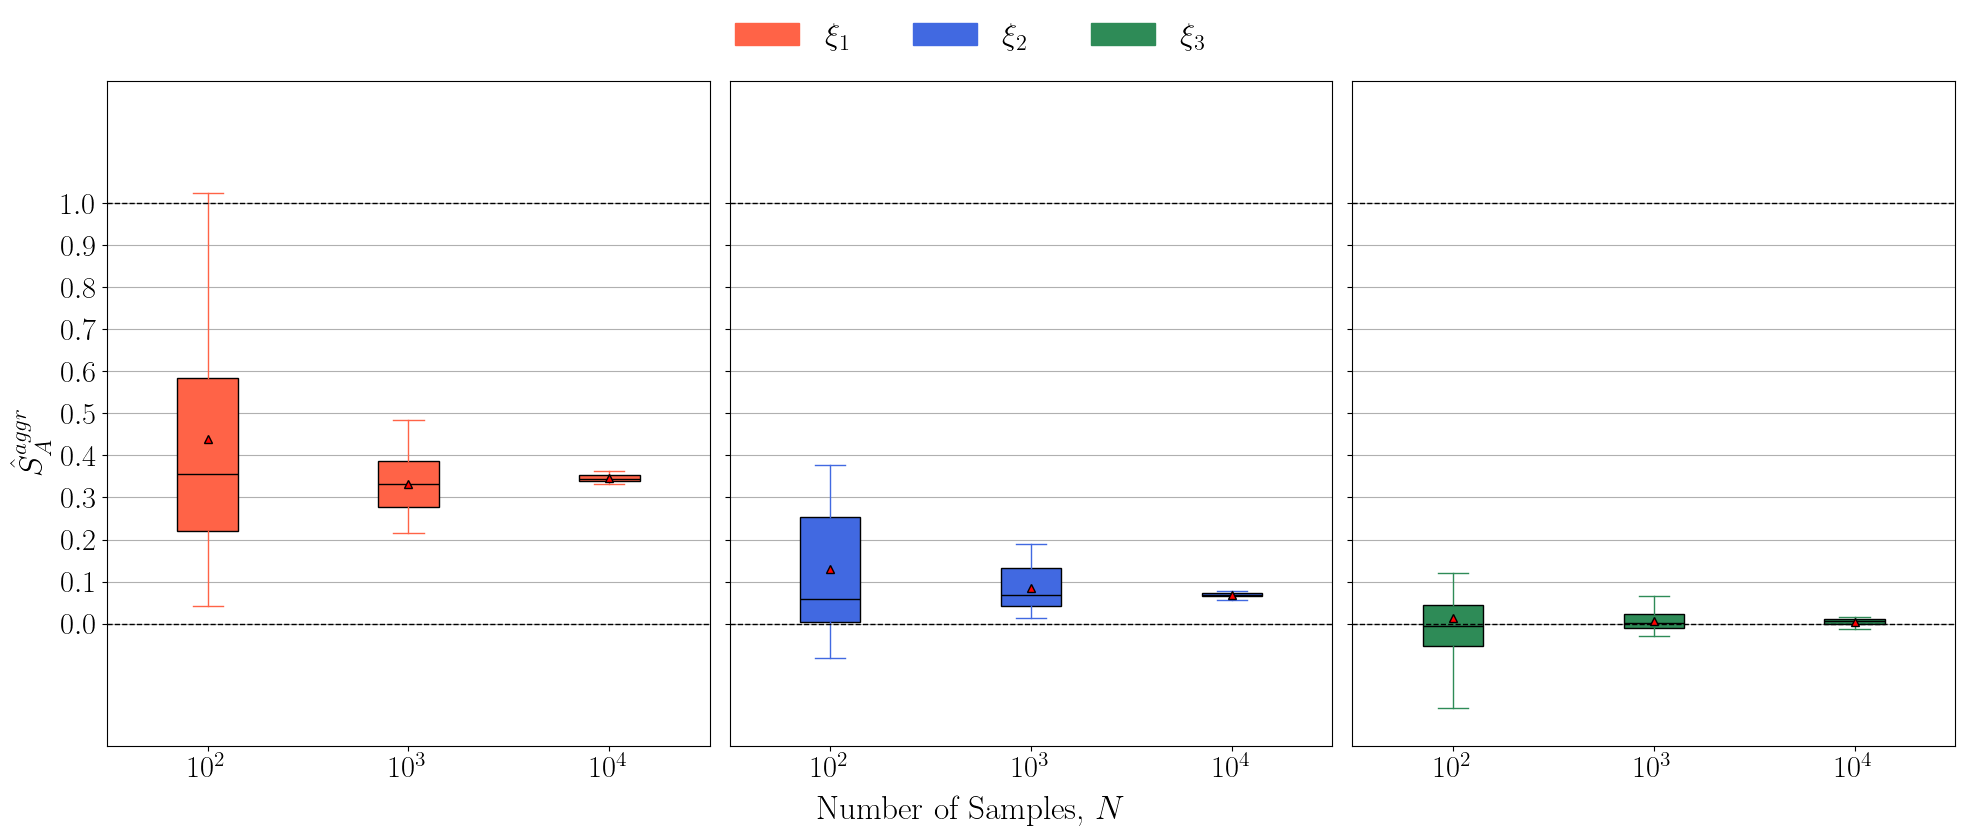

1d_diffusion_<0_45,0_55>_Nset_<100,1000,10000>_h_1024_constraint_0.135
Showing plot for interval: [0.45,0.55]


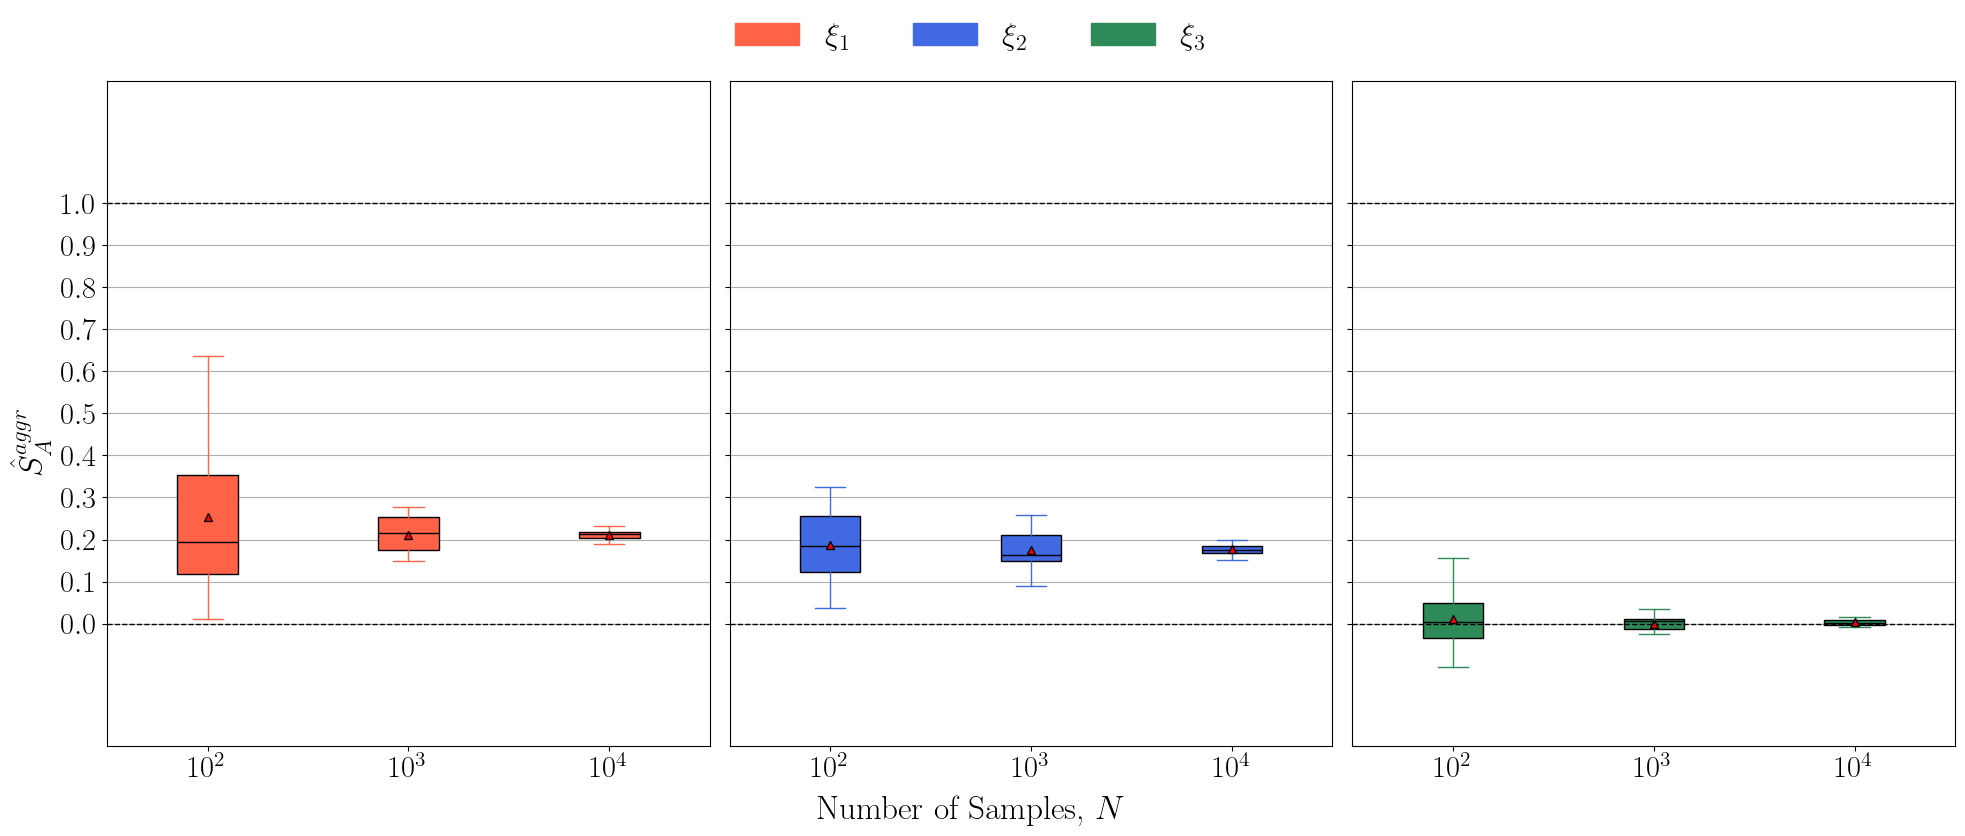

1d_diffusion_<0_0,1_0>_Nset_<100,1000,10000>_h_1024_constraint_0.135
Showing plot for interval: [0.0,1.0]


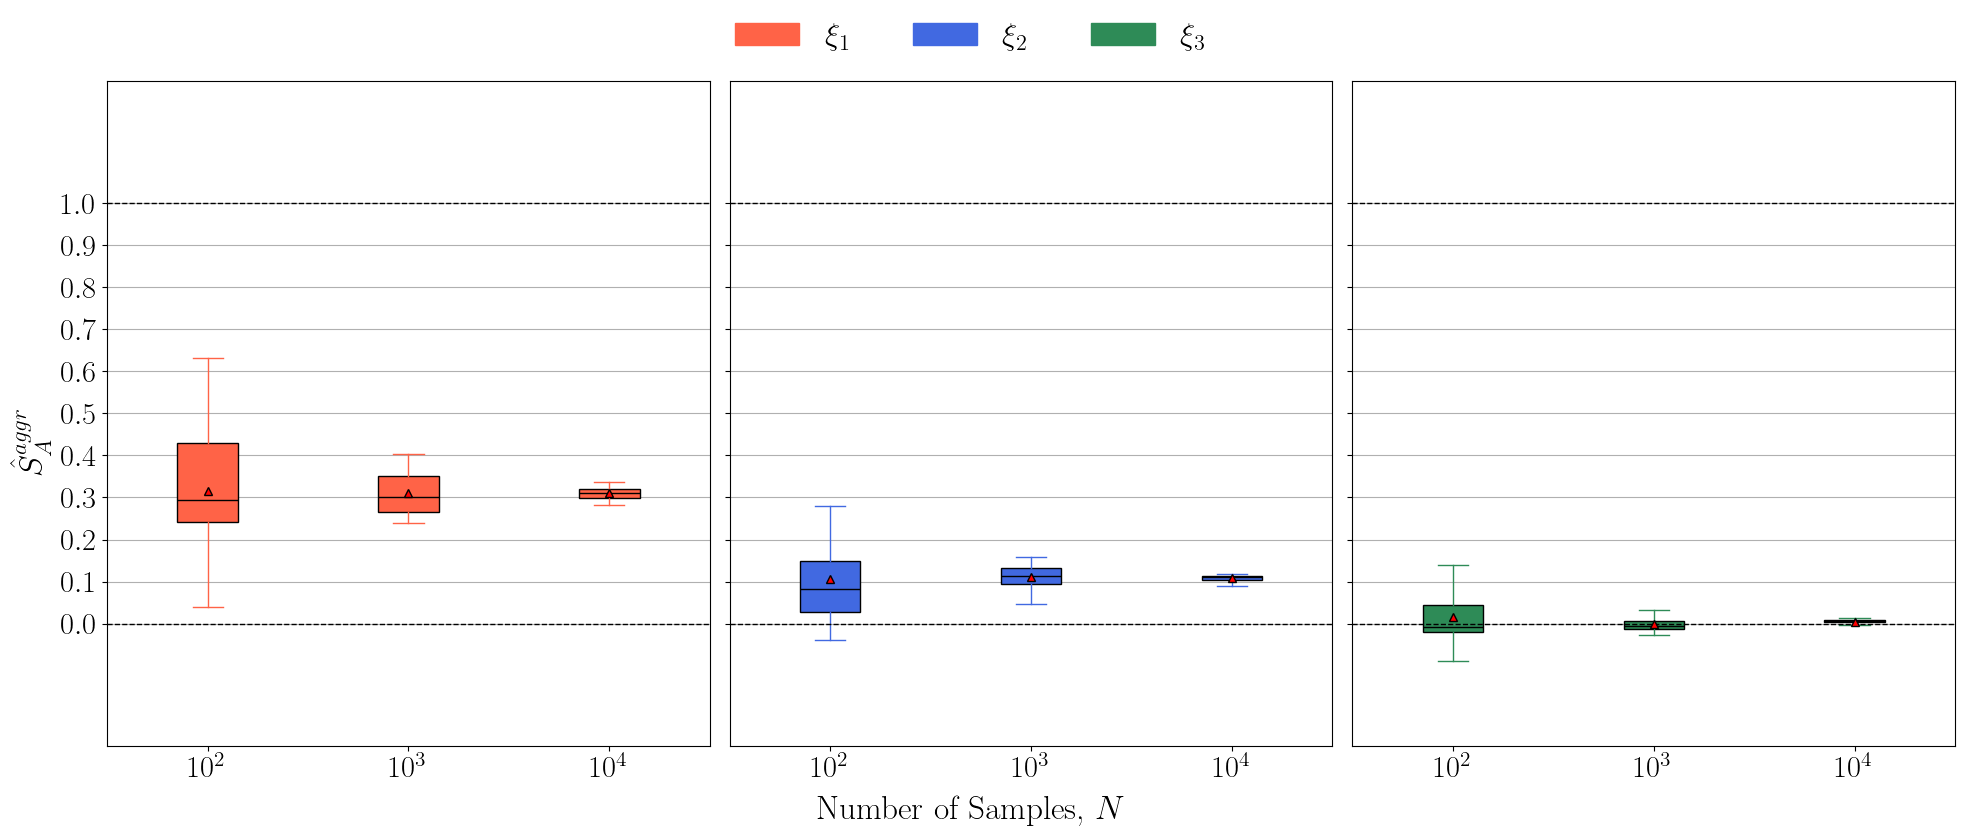

1d_diffusion_<0_6,1_0>_Nset_<100,1000,10000>_h_1024_constraint_0.135
Showing plot for interval: [0.6,1.0]


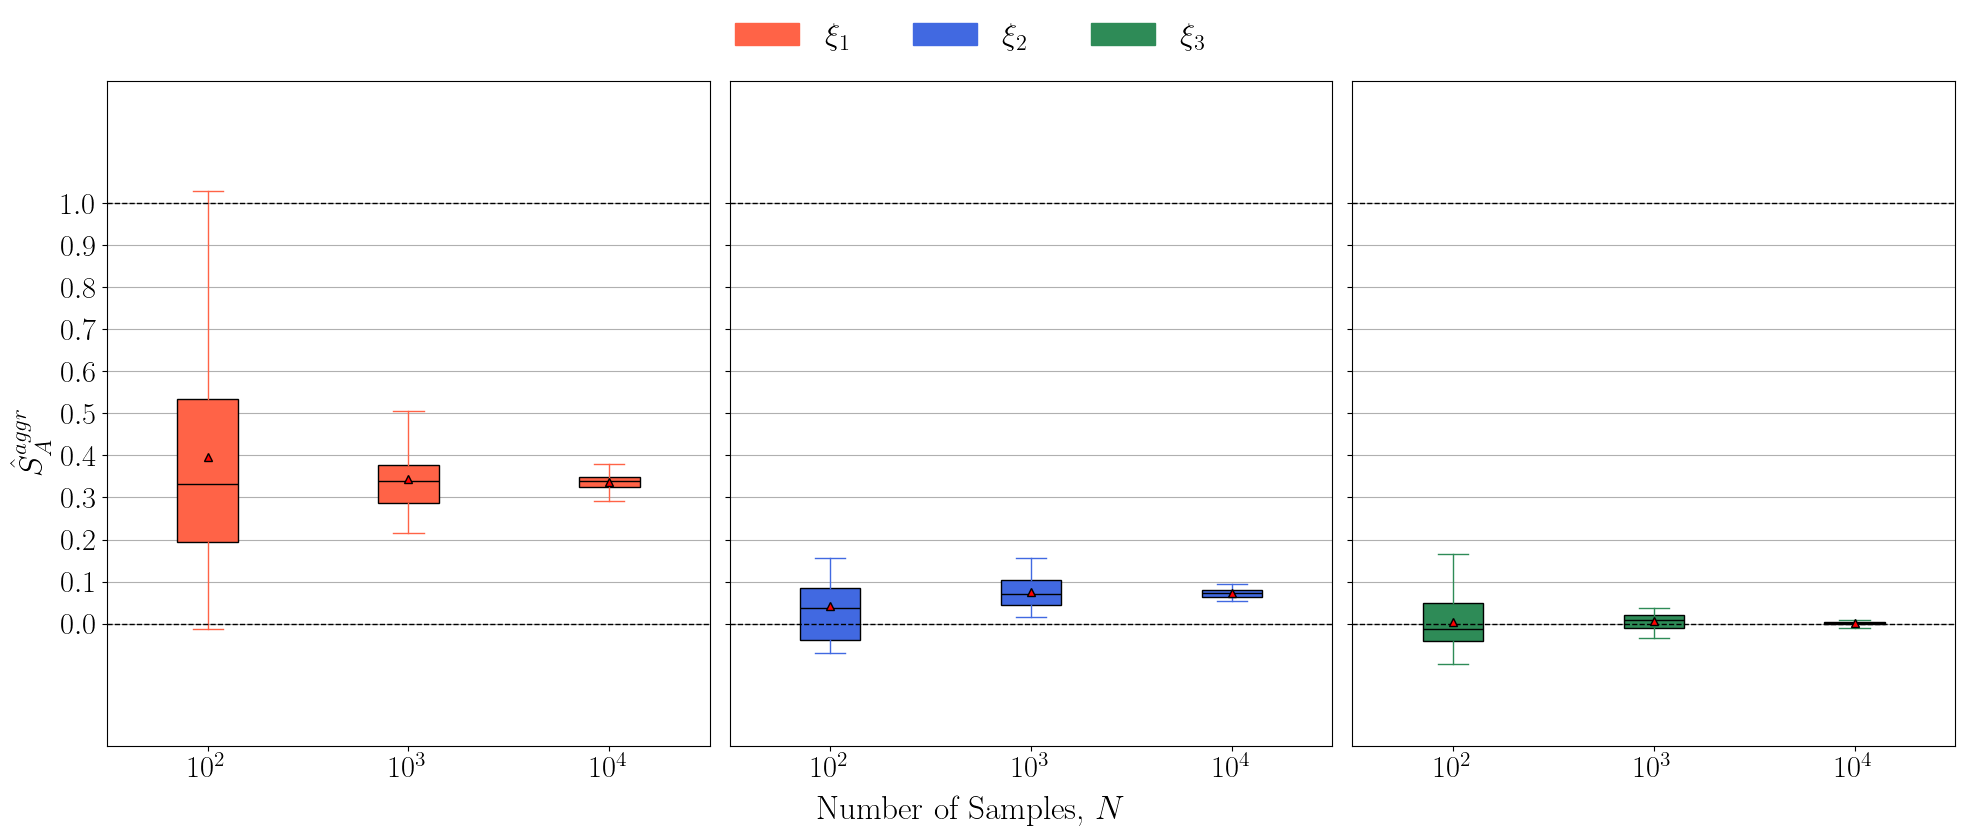

In [ ]:
from utils import plotter
import re
for file in files:
    model = load_model(load_dir=file)
# for model in diffuFen_models_list:
    if 10000 not in model.N_set:
        continue
    file_name = file[len(file_sup_dir)+1:-4]
    print(file_name)
    plotter.plot(model=model,
                N_set=model.N_set,
                only_singulars=True,
                withOutliers=False,
                withTrend=False,
                grid_toggle=True,
                base_fontsize=22,
                save_fig=True,
                save_directory='figs/1d_diffusion/vbsa/traced',
                fig_name=file_name)
                # save_directory='figs/toy_2/pick_freeze/traced',
                # fig_name=f'toy_2_convergence_{save_name}.pdf')

# $\text{Affine Linear Function}\;g_1$
## Vectorized-Set-Output

In [1]:
from utils import numeric_models as nm
from utils import solvers
from utils.other_utils import save_model
import time
import numpy as np
from os import makedirs, path

In [ ]:
indicator_flag = True
indicator_constraint_val = 3.75
x_interval_domain = [0.25, 0.75]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_1/pick_freeze/indicator'
else:
    save_dir = 'data/g_1/pick_freeze/non_indicator'
makedirs(save_dir, exist_ok=True)
save_name = f"toy_1_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [4]:
toy_1_models_list = []
t0 = time.time()
toy_1_vect = nm.model(model_type='toy_1_vect', vectSize=3)
toy_1_vect.indicator = indicator_flag
toy_1_vect.constraintVal = indicator_constraint_val
toy_1_vect.meshInterval = x_interval_mesh_resolution
toy_1_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_1_vect, N_set=N_set)
toy_1_models_list.append(toy_1_vect)

save_model(model=toy_1_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

Model saved successfully.
Done | T: 416.641s


#### Load data from file

In [ ]:
from glob import glob
from utils.other_utils import load_model
toy_1_models_list = []
files = glob("data/g_1/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_1_models_list.append(load_model(load_dir=file))
toy_1_models_list

data/toy_1/pick_freeze/indicator/toy_1_model_file__exprimentNum_20__Nset_100_1000_10000__xInterval_0.25_0.75__h_128__constraintVal_3_75.pkl


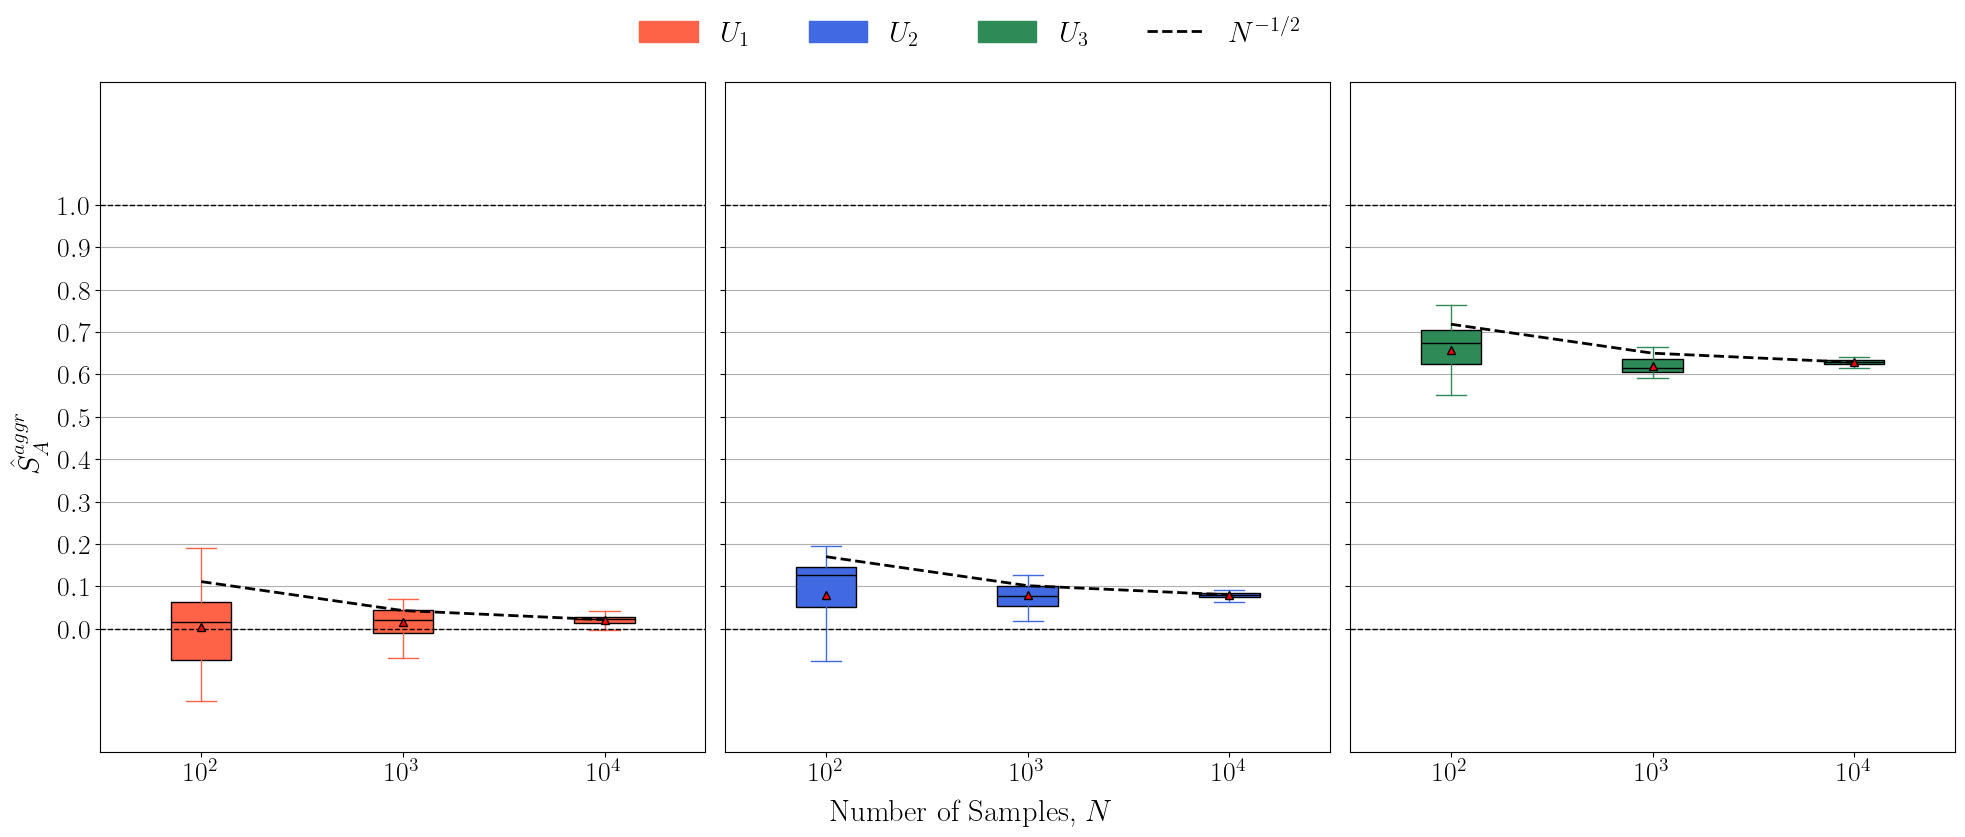

In [ ]:
from utils import plotter
for model in toy_1_models_list:
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=True,
                grid_toggle=True,
                save_directory='figs/g_1/pick_freeze/traced',
                fig_name=f'g_1_convergence_{save_name}.pdf')

# $\text{Affine Linear Function}\;g_2$ 
## Vectorized-Set-Output

In [6]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob
import time
import numpy as np
from os import makedirs, path
import matplotlib.pyplot as plt

In [ ]:
indicator_flag = True
indicator_constraint_val = 5.25
x_interval_domain = [0.25, 0.75]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_2/pick_freeze/indicator'
else:
    save_dir = 'data/g_2/pick_freeze/non_indicator'
makedirs(save_dir, exist_ok=True)
save_name = f"g_2_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [ ]:
toy_2_models_list = []
t0 = time.time()
toy_2_vect = nm.model(model_type='toy_2_vect', vectSize=3)
toy_2_vect.indicator = indicator_flag
toy_2_vect.constraintVal = indicator_constraint_val
toy_2_vect.meshInterval = x_interval_mesh_resolution
toy_2_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_2_vect, N_set=N_set)
toy_2_models_list.append(toy_2_vect)
save_model(model=toy_2_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

Model saved successfully.
Done | T: 438.650s


In [ ]:
toy_2_models_list = []
files = glob("data/g_2/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_2_models_list.append(load_model(load_dir=file))
toy_2_models_list

data/toy_2/pick_freeze/indicator/toy_2_model_file__exprimentNum_20__Nset_100_1000_10000__xInterval_0.25_0.75__h_128__constraintVal_5_25.pkl


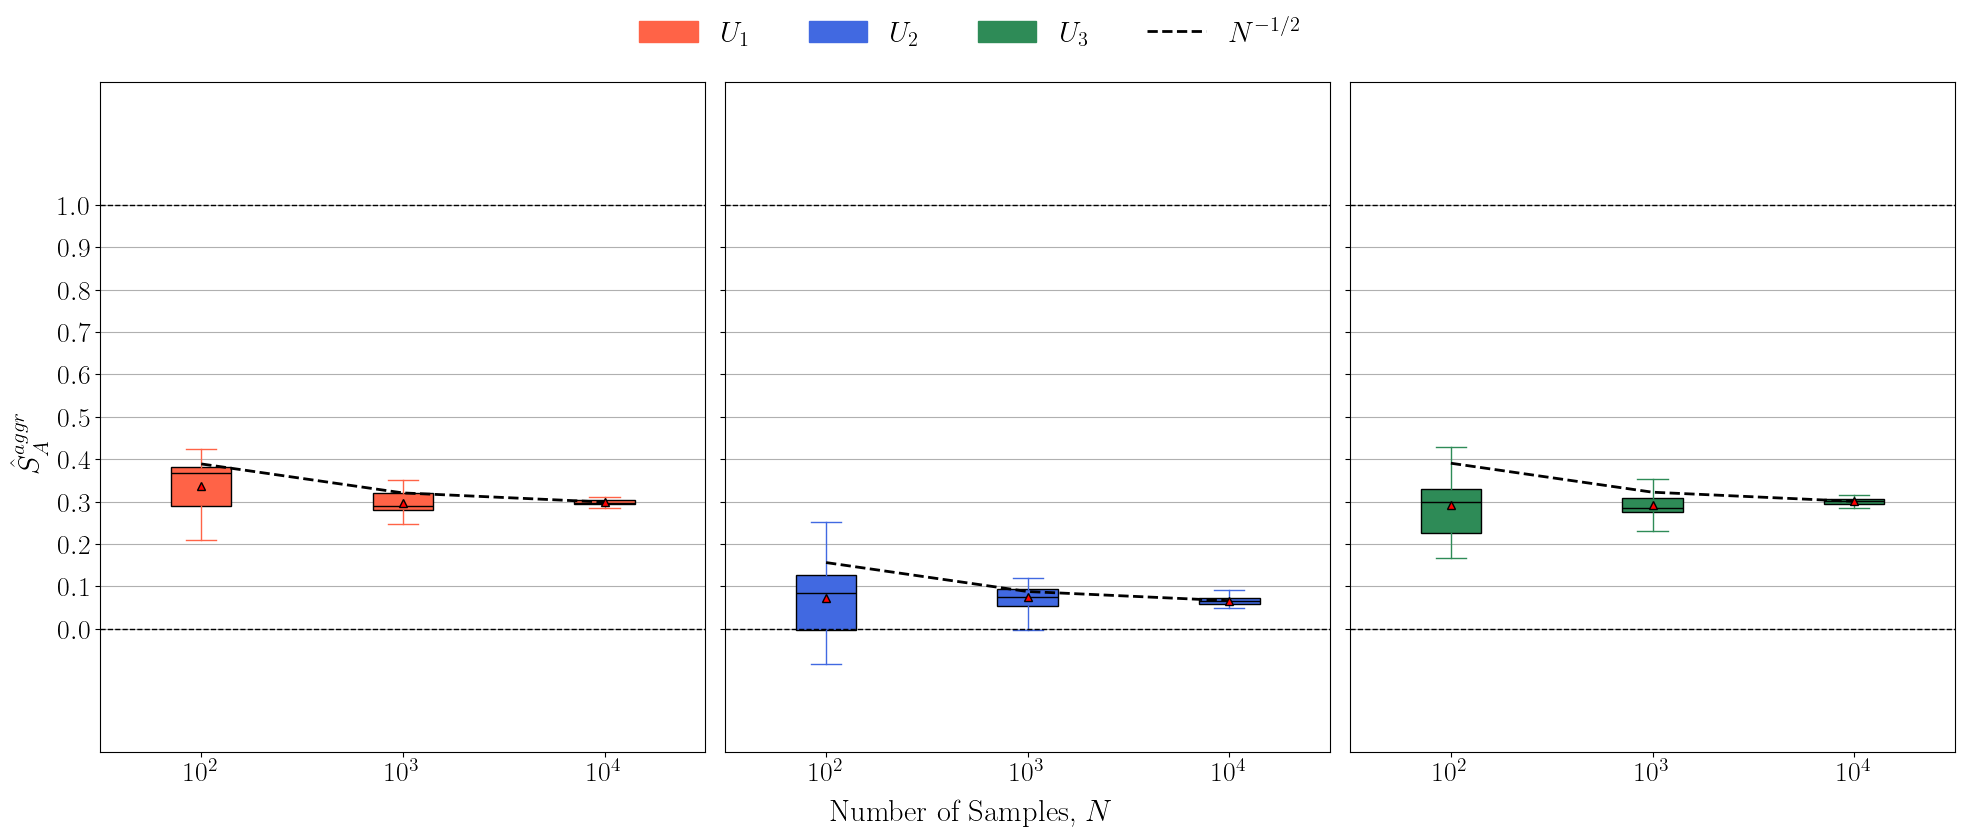

In [ ]:
for model in toy_2_models_list:
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=True,
                grid_toggle=True,
                save_directory='figs/g_2/pick_freeze/traced',
                fig_name=f'g_2_convergence_{save_name}.pdf')

# $\text{Nonlinear Problem}\;g_3$
## Vectorized-Set-Output

### $\;\mathbf{y} = (\mathbb{1}_{\{y_1\leq 0\}},...,\mathbb{1}_{\{y_{h+1}\leq 0\}})^T$,
### $y_i=G(X,U)=u_1+u_1u_2+x^{(i)}_hu_1$, 
### $\quad u_i\sim \mathbb{U}[ -1,1],\; i\in\{1,2\}$, 
### $\quad x\in[ -1,1] \rightarrow x_h\in\{-1,-1+\frac{1-(-1)}{h},...,1\}\;\;h\in\mathbb{N}_{>0}$.

#### Imports

In [ ]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import load_model, save_model
from glob import glob
import time
import numpy as np
from os import makedirs, path

### Calculating aggr' sobols via trace

#### Setup

In [ ]:
# interval_domain = [-np.pi, -2.0]
# interval_mesh_resolution = 8
# ishigami_indicator_constraint_val = 3
indicator_flag = True
indicator_constraint_val = 0.0
x_interval_domain = [-1.0, 1.0]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_3/pick_freeze/indicator'
else:
    save_dir = 'data/g_3/pick_freeze/non_indicator'
# save_dir += f'{list(np.round(interval_domain,2))}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
# save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
makedirs(save_dir, exist_ok=True)
toy_model_vect_models_list = []
save_name = f"g_3_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [ ]:
t0 = time.time()
toy_model_vect = nm.model(model_type='toy_model_vect', vectSize=2)
toy_model_vect.indicator = indicator_flag
toy_model_vect.constraintVal = indicator_constraint_val
toy_model_vect.meshInterval = x_interval_mesh_resolution
toy_model_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_model_vect, N_set=N_set)
toy_model_vect_models_list.append(toy_model_vect)


save_model(model=toy_model_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

Model saved successfully.
Done | T: 154.767s


#### Load data 

In [ ]:
toy_model_vect_models_list = []
files = glob("data/g_3/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_model_vect_models_list.append(load_model(load_dir=file))
toy_model_vect_models_list

data/toy_3/pick_freeze/indicator/toy_model_vect_model_file__exprimentNum_20__Nset_100_1000_10000__xInterval_neg1.0_1.0__h_128__constraintVal_0_0.pkl


#### Plot

toy_model_vect_model_file__exprimentNum_20__Nset_100_1000_10000__xInterval_neg1.0_1.0__h_128__constraintVal_0_0.pkl


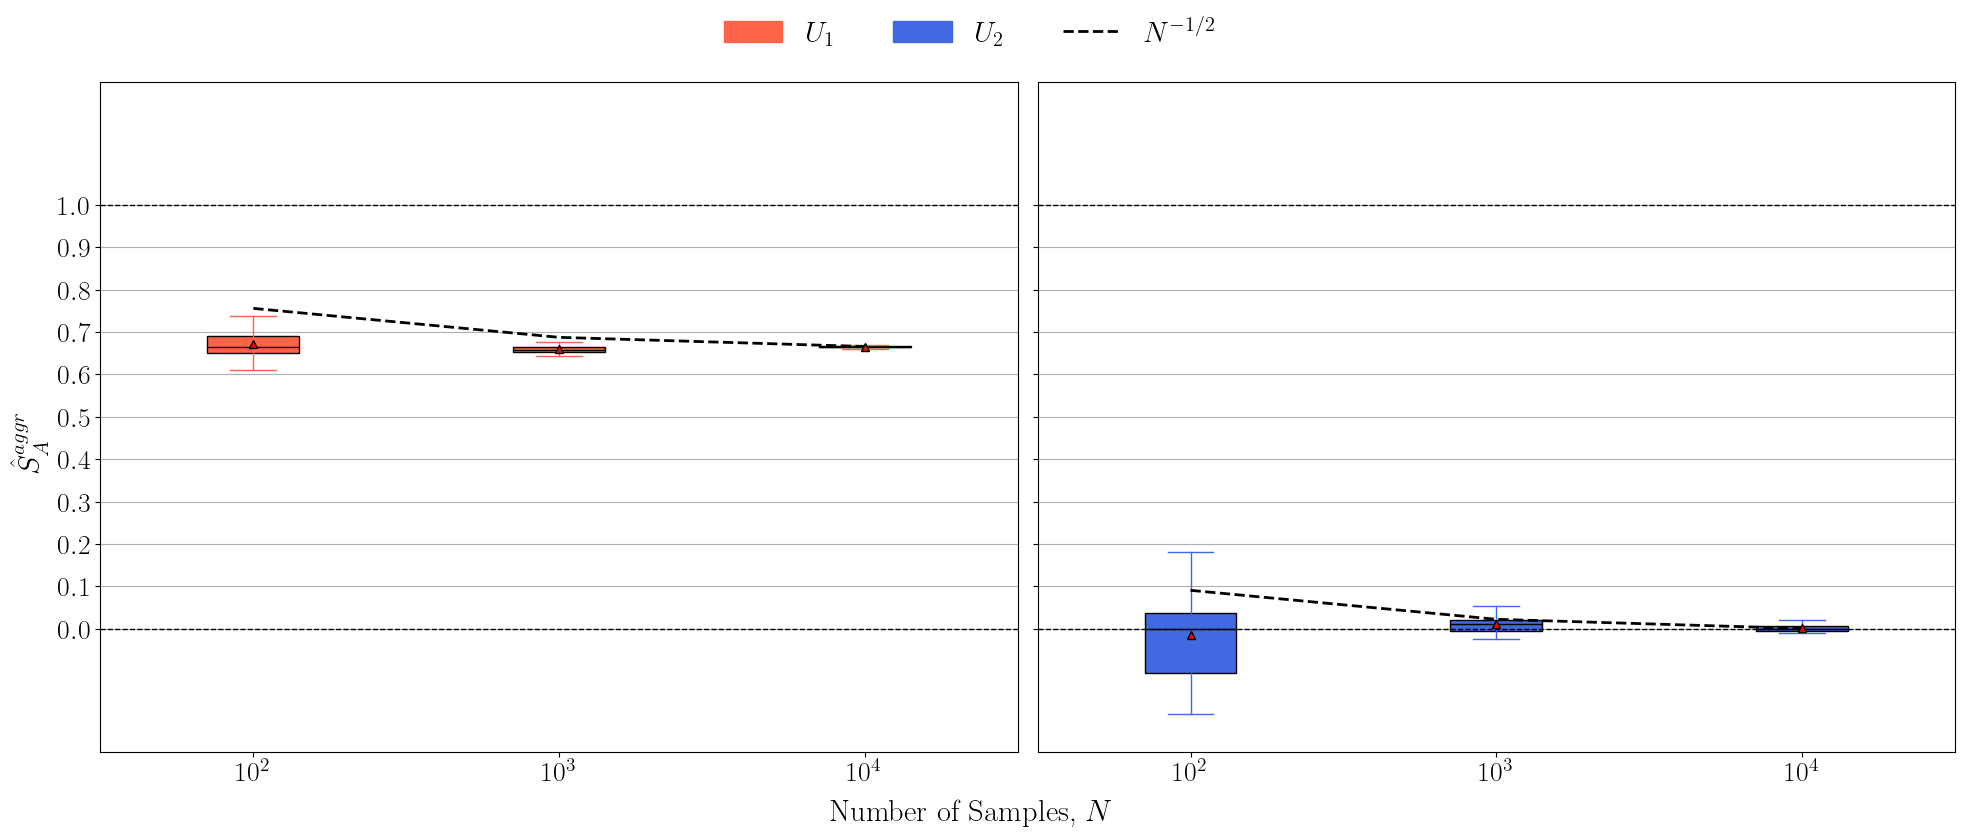

In [21]:
for model, file_dir in zip(toy_model_vect_models_list, files):
    fig_name = path.basename(file_dir).replace('.dill','.pdf')
    fig_name = path.basename(file_dir).replace('.pkl','.pdf')
    save_dir = path.dirname(file_dir)
    model.specifyX3 = True
    model.x_3 = 0
    print(fig_name)
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=False,
                grid_toggle=True,
                save_directory='figs/g_3/pick_freeze/traced',
                fig_name=f'g_3_convergence_{save_name}.pdf')

----------